In [2]:
import pandas as pd
import numpy as np
import sqlite3
import re
import unicodedata
from pathlib import Path
import plotly.express as px
import warnings
import os
from datetime import datetime
from tqdm import tqdm
import pycountry
import random
import string
from datetime import datetime, timedelta
import requests
import statsmodels.api as sm
import matplotlib.pyplot as plt


def clean_ecommerce_dataset(
    sqlite_db_path: str = r"C:\Users\user\Ecommerce.db",
    run_tables=("customers", "orders", "products", "reviews"),
    save_to_sqlite: bool = False
    ):
    """
    ETL pipeline for E-commerce Dataset.
    """
    print("=" * 80)
    print("ECOMMERCE DATASET CLEANING PIPELINE")
    print("=" * 80)

    # ------------------- CONFIG ------------------------------------
    warnings.filterwarnings("ignore")
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_rows", 50)
    pd.set_option("display.float_format", lambda x: f"{x:.2f}")

    # ------------------- CHECK DATABASE EXISTS ----------------------
    if not Path(sqlite_db_path).exists():
        raise FileNotFoundError(f"Database file not found: {sqlite_db_path}")

    # ------------------- CONNECTION SETUP --------------------------
    conn = sqlite3.connect(sqlite_db_path)

    try:
        # ------------------- EXTRACTION --------------------------------
        print("\n1. EXTRACTING DATA...")
        print("=" * 80)

        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        available_tables = [row[0] for row in cursor.fetchall()]

        tables_to_load = [t for t in run_tables if t in available_tables]

        if not tables_to_load:
            raise RuntimeError(f"No requested tables found. Available: {available_tables}")

        dataframes = {}
        for table in tables_to_load:
            df = pd.read_sql_query(f"SELECT * FROM [{table}]", conn)  # [] to handle reserved names
            dataframes[table] = df
            print(f"Loaded {table}: {df.shape}")

        # --------------------------------- 2. TRANSFORMATION PHASE --------------------------
        print("\n" + "=" * 80)
        print("2. TRANSFORMING DATA...")
        print("=" * 80)

        cleaned_tables = {}

        # ----------------------------- CUSTOMERS TABLE -----------------------------
        if "customers" in dataframes:
            print("Cleaning customers table")

            df = dataframes["customers"].copy()

            # customer_id
            df["customer_id"] = df["customer_id"].astype(str).str.strip()
            df["customer_id"] = df["customer_id"].replace(["", "nan", "None", "NULL", "<NA>"], np.nan)
            df["customer_id"] = df["customer_id"].fillna("Unknown")

            # Name fields
            name_columns = ["first_name", "last_name"]
            for col in name_columns:
                if col in df.columns:
                    df[col] = df[col].astype(str).str.strip()
                    df[col] = df[col].replace(["", "nan", "None", "NULL"], np.nan)
                    df[col] = df[col].str.title()
                    df[col] = df[col].fillna("Unknown")

            # Full name
            def build_full_name(row):
                first = row["first_name"]
                last = row["last_name"]
                if first != "Unknown" and last != "Unknown":
                    return f"{first} {last}"
                elif first != "Unknown":
                    return first
                elif last != "Unknown":
                    return last
                else:
                    return "Unknown"

            df["full_name"] = df.apply(build_full_name, axis=1)

            #-------------COUNTRY---------------------------------
            if "country" in df.columns:
                df["country"] = df["country"].str.title().fillna("Unknown")

                # COUNTRY STANDARDIZATION
                def standardize_country(country):
                    if country == "Unknown":
                        return "Unknown"
                    try:
                        return pycountry.countries.lookup(country).name
                    except LookupError:
                        # Try partial match or common variants
                        variants = {
                            "United States": "United States of America",
                            "USA": "United States of America",
                            "UK": "United Kingdom",
                            "U.K.": "United Kingdom",
                        }
                        return variants.get(country, country)

                df["country"] = df["country"].apply(standardize_country)

            # Dates
            date_cols = ["registration_date", "date_of_birth"]
            for col in date_cols:
                if col in df.columns:
                    df[col] = pd.to_datetime(df[col], errors="coerce")

            if "last_login" in df.columns:
                df["last_login"] = pd.to_datetime(df["last_login"], errors="coerce")
                df["last_login_date"] = df["last_login"].dt.date
                df["last_login_time"] = df["last_login"].dt.time
                df = df.drop(columns=["last_login"], errors="ignore")

            if "account_age_days" in df.columns:
                    
                    # 1. Normalize placeholders & coerce to numeric
                    df["account_age_days"] = df["account_age_days"].replace(
                        {
                            "Unknown": np.nan,
                            "unknown": np.nan,
                            "": np.nan,
                            pd.NA: np.nan
                        }
                    )

                    df["account_age_days"] = pd.to_numeric(df["account_age_days"], errors="coerce")

                    # 2. Convert negative values to positive
                    df["account_age_days"] = df["account_age_days"].abs()

                    valid_vals = df["account_age_days"].dropna()

                    if not valid_vals.empty:
                        rng = np.random.default_rng(seed=42)
                        min_val = valid_vals.min()
                        max_val = valid_vals.max()

                        nan_mask = df["account_age_days"].isna()
                        df.loc[nan_mask, "account_age_days"] = rng.integers(
                            low=int(min_val),
                            high=int(max_val) + 1,
                            size=nan_mask.sum()
                        )

            # Boolean columns
            boolean_columns = ["newsletter_subscribed", "marketing_consent"]
            boolean_map = {
                "true": True, "false": False, "yes": True, "no": False,
                "y": True, "n": False, "1": True, "0": False,
                True: True, False: False
            }
            for col in boolean_columns:
                if col in df.columns:
                    df[col] = (
                        df[col]
                        .astype(str)
                        .str.strip()
                        .str.lower()
                        .replace(["", "nan", "none", "null"], np.nan)
                        .map(boolean_map)
                    )
            # Credit tier--
            if "credit_tier" in df.columns:
                df["credit_tier"] = (df["credit_tier"].astype(str).str.strip().str.upper())

            # Preferred language
            if "preferred_language" in df.columns:
                language_map = {"ESPAÑOL": "ES", "SPANISH": "ES", "ENGLISH": "EN", "NONE": "EN"}
                df["preferred_language"] = (
                    df["preferred_language"]
                    .astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(language_map)
                    .replace(["", "NAN", "NONE", "NULL",], np.nan)
                    .fillna("EN")
                )

            # Currency preference
            if "currency_preference" in df.columns:
                currency_map = {"$": "USD", "£": "GBP", "€": "EUR", "¥": "JPY"}
                df["currency_preference"] = (
                    df["currency_preference"]
                    .astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(currency_map)
                    .replace(['  ',"", "NAN", "NONE", "NULL"], np.nan)
                )

            # Customer status
            if "customer_status" in df.columns:
                df["customer_status"] = (
                    df["customer_status"]
                    .astype(str)
                    .str.strip()
                    .str.title()
                    .replace(["", "Nan", "None", "Null"], np.nan)
                    .fillna("Unknown")
                )

            # Gender
            if "gender" in df.columns:
                gender_map = {
                    "m": "Male", "male": "Male",
                    "f": "Female", "female": "Female",
                    "other": "Other", "o": "Other"
                }
                df["gender"] = (
                    df["gender"]
                    .astype(str)
                    .str.strip()
                    .str.lower()
                    .replace(["", "nan", "none", "null"], np.nan)
                    .map(gender_map)
                    .fillna("Unknown")
                )

            # Numeric financial columns
            numeric_columns = ["total_spent", "avg_order_value", "loyalty_score"]
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors="coerce")
            
            #drop tables
            drop_columns = ["email","phone","address","city","state","last_login","first_name","last_name","address_line1","last_login_time","last_login_date","zip_code","last_login_date"]
            df = df.drop(columns=[col for col in drop_columns if col in df.columns]) 

            #Droping duplicates and removing nan and unknown
            df = df.drop_duplicates()
            df = df[
                df["customer_id"].notna()
                & (df["customer_id"] != "Unknown")
                & df["country"].notna()
                & (df["country"] != "Unknown")
                & df["date_of_birth"].notna()
                & df["registration_date"].notna()
            ]

            # Numeric columns outliers, missing values and duplicate fix
            df["avg_order_value"]= df["avg_order_value"].abs()
            df["total_spent"]= df["total_spent"].abs()
            df["loyalty_score"]= df["loyalty_score"].abs()
            df["account_age_days"]= df["account_age_days"].abs()
            numeric_columns = ["account_age_days","loyalty_score","total_spent","avg_order_value"]
            for col in numeric_columns:
                if col in df.columns:
                    q1 = df[col].quantile(0.25)
                    q3 = df[col].quantile(0.75)
                    iqr = q3 - q1

                    lower_bound = q1 - 1.5 * iqr
                    upper_bound = q3 + 1.5 * iqr

                    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound),col] = np.nan
            rng = np.random.default_rng(seed=42)  # reproducible

            for col in numeric_columns:
                if col in df.columns:
                    valid_values = df[col].dropna()
                    # Safety check
                    if not valid_values.empty:
                        min_val = valid_values.min()
                        max_val = valid_values.max()
                        nan_mask = df[col].isna()
                        n_missing = nan_mask.sum()

                        df.loc[nan_mask, col] = rng.uniform(low=min_val,high=max_val,size=n_missing)
            #df["account_age_days"] = df["account_age_days"].round(0).astype("Int64")

            # =========================================================
            # CATEGORICAL COLUMNS — MODE IMPUTATION
            # =========================================================

            categorical_cols = ["customer_status","newsletter_subscribed","preferred_language","currency_preference","marketing_consent","gender","credit_tier"]
            for col in categorical_cols:
                if col in df.columns:

                    # Normalize placeholders
                    df[col] = df[col].replace({"Unknown": np.nan,"unknown": np.nan,"": np.nan,pd.NA: np.nan})
                    # Compute mode safely
                    if not df[col].dropna().empty:
                        mode_value = df[col].mode(dropna=True)[0]

                        # Fill missing with mode
                        df[col] = df[col].fillna(mode_value)

            print("Customers cleaning completed")
            cleaned_tables["customers"] = df

        # ----------------------------- ORDERS TABLE (example stub) -----------------------------
        if "orders" in dataframes:
            print("Cleaning orders table (basic)")
            df1 = dataframes["orders"].copy()

            id_columns = ["order_id", "customer_id", "product_id"]
            for col in id_columns:
                if col in df1.columns:
                    df1[col] = (df1[col].astype(str).str.strip()
                        .replace(["", "nan", "None", "NULL"], np.nan))
            #------Date columns------------------------
            date_columns = ["order_date","estimated_delivery","actual_delivery"]
            for col in date_columns:
                if col in df1.columns:
                    df1[col] = pd.to_datetime(df1[col],errors="coerce",infer_datetime_format=True)
            # 2. Split into separate columns
            df1["order_date_date"] = df1["order_date"].dt.date
            df1["order_date_time"] = df1["order_date"].dt.time

            # 3. Drop original column
            df1.drop(columns=["order_date"], inplace=True)

            #--------------FIXING NUMERIC COLUMNS-----------------
            numeric_columns = ["order_amount","quantity","shipping_cost","tax_amount","total_amount","discount_amount"]
            for col in numeric_columns:
                if col in df1.columns:
                    # Remove non-numeric characters (keep minus & decimal)
                    df1[col] = (df1[col].astype(str).str.replace(r"[^\d\.\-]", "", regex=True))
                    df1[col] = pd.to_numeric(df1[col], errors="coerce")
                    # Convert negatives to positives
                    df1[col] = df1[col].abs()
                    # Rounding rules
                    if col == "quantity":
                        df1[col] = df1[col].round(0)
                    else:
                        df1[col] = df1[col].round(3)

            # ORDER CATEGORICAL COLUMNS — NORMALIZATION + MODE IMPUTATION
            
            # Helper to normalize missing placeholders
            def _normalize_missing(series):
                return series.replace(
                    {
                        "": np.nan,
                        "nan": np.nan,
                        "NaN": np.nan,
                        "None": np.nan,
                        "NONE": np.nan,
                        "null": np.nan,
                        "NULL": np.nan,
                        "Unknown": np.nan,
                        "UNKNOWN": np.nan,
                        pd.NA: np.nan
                    }
                )

            # -------------------------
            # -------------------------
            # PAYMENT METHOD (TITLE CASE ONLY)
            # -------------------------
            if "payment_method" in df1.columns:
                df1["payment_method"] = (
                    df1["payment_method"]
                    .astype(str)
                    .str.strip()
                    .str.upper()
                    .replace({
                        "CREDIT CARD": "CREDIT CARD",
                        "CREDIT_CARD": "CREDIT CARD",
                        "CARD": "CREDIT CARD",
                        "PAYPAL": "PAYPAL",
                        "APPLE PAY": "APPLE PAY",
                        "APPLE_PAY": "APPLE PAY",
                        "GOOGLE PAY": "GOOGLE PAY",
                        "GOOGLE_PAY": "GOOGLE PAY",
                        "BANK TRANSFER": "BANK TRANSFER",
                        "BANK_TRANSFER": "BANK TRANSFER",
                        "CASH": "CASH"
                    })
                    .pipe(_normalize_missing)
                )

                # Final format → Title Case ONLY
                df1["payment_method"] = df1["payment_method"].str.title()

                # Mode imputation
                if not df1["payment_method"].dropna().empty:
                    mode_payment_method = df1["payment_method"].mode(dropna=True)[0]
                    df1["payment_method"] = df1["payment_method"].fillna(mode_payment_method)

            # -------------------------
            # SHIPPING METHOD
            # -------------------------
            if "shipping_method" in df1.columns:df1["shipping_method"] = (df1["shipping_method"].astype(str).str.strip().str.title().pipe(_normalize_missing))
            # Mode imputation
            if not df1["shipping_method"].dropna().empty:
                mode_shipping = df1["shipping_method"].mode(dropna=True)[0]
                df1["shipping_method"] = df1["shipping_method"].fillna(mode_shipping)

            # -------------------------
            # ORDER STATUS
            # -------------------------
            if "order_status" in df1.columns:df1["order_status"] = (df1["order_status"].astype(str).str.strip().str.title().pipe(_normalize_missing))
            # Mode imputation
            if not df1["order_status"].dropna().empty:
                mode_order_status = df1["order_status"].mode(dropna=True)[0]
                df1["order_status"] = df1["order_status"].fillna(mode_order_status)

             # -------------------------
            # PAYMENT METHOD
            # --------------------------
            if "payment_method" in df1.columns:
                df1["payment_method"] = (df1["payment_method"].astype(str).str.strip().str.upper().replace(
                    {
                        "CARD": "Credit_card",
                        "Credit Card":"Credit_card"
                        
                    }
                )
                .str.title()
                .pipe(_normalize_missing)
            )

            # Mode imputation
            if not df1["payment_method"].dropna().empty:
                mode_payment_method = df1["payment_method"].mode(dropna=True)[0]
                df1["payment_method"] = df1["payment_method"].fillna(mode_payment_method)

            # -------------------------
            # -------------------------
            # CURRENCY CLEANING
            # -------------------------
            if "currency" in df1.columns:
                currency_map = {
                    "USD": "USD",
                    "EUR": "EUR",
                    "GBP": "GBP"
                }

                df1["currency"] = (
                    df1["currency"]
                    .astype(str)
                    .str.strip()                      # remove whitespace
                    .replace({"": np.nan, "None": np.nan})  # empty → NaN
                    .str.upper()
                    .map(currency_map)
                )

                # Fill missing currencies with mode
                mode_currency = df1["currency"].mode(dropna=True)[0]
                df1["currency"] = df1["currency"].fillna(mode_currency)

            # =========================================================
            # WAREHOUSE — MODE IMPUTATION (NO CASE CHANGE)
            # =========================================================

            if "warehouse_id" in df1.columns:
    
                # 1. Normalize missing placeholders
                df1["warehouse_id"] = (
                    df1["warehouse_id"].astype(str).str.strip().replace(
                        {
                            "": np.nan,
                            "nan": np.nan,
                            "NaN": np.nan,
                            "None": np.nan,
                            "null": np.nan,
                            "NULL": np.nan,
                            "Unknown": np.nan,
                            "UNKNOWN": np.nan,
                            pd.NA: np.nan
                        }
                    )
                )

                # 2. Fill missing with mode
                if not df1["warehouse_id"].dropna().empty:
                    mode_warehouse = df1["warehouse_id"].mode(dropna=True)[0]
                    df1["warehouse_id"] = df1["warehouse_id"].fillna(mode_warehouse)
                
            # =========================================================
            #        CHANNEL — TITLE CASE + MODE IMPUTATION
            # =========================================================

            if "channel" in df1.columns:

                # 1. Normalize placeholders
                df1["channel"] = (df1["channel"].astype(str).str.strip()
                    .replace(
                        {
                            "": np.nan,
                            "nan": np.nan,
                            "NaN": np.nan,
                            "None": np.nan,
                            "NONE": np.nan,
                            pd.NA: np.nan
                        }
                    )
                )

                # 2. Convert to Title Case
                df1["channel"] = df1["channel"].str.title()

                # 3. Fill missing with mode
                if not df1["channel"].dropna().empty:
                    mode_channel = df1["channel"].mode(dropna=True)[0]
                    df1["channel"] = df1["channel"].fillna(mode_channel)
            
            def get_exchange_rates(base="USD"):
                url = f"https://open.er-api.com/v6/latest/{base}"
                response = requests.get(url)
                response.raise_for_status()
                return response.json()["rates"]

            rates = get_exchange_rates("USD")
            order_money_columns = ["order_amount","shipping_cost","tax_amount","total_amount","discount_amount"]

            for col in order_money_columns:
                if col in df1.columns:
                    df1[f"{col}_usd"] = df1.apply(
                        lambda row: (
                            row[col] / rates[row["currency"]]
                            if pd.notna(row[col]) and row["currency"] in rates
                            else np.nan
                        ),
                        axis=1
                    )

            # -----------------------------------------------------------------------
            #                DROP UNUSED / UNWANTED COLUMNS (UPDATED)
            # -----------------------------------------------------------------------
            drop_columns = ["shipping_address","sales_rep_id","return_reason","discount_code","notes","shipping_address_same"]
            df1 = df1.drop(columns=[col for col in drop_columns if col in df1.columns])

            cleaned_tables["orders"] = df1
            print("Orders cleaning completed")

        # -----------------------------------------------------------------------------------------------
        # ========================================REVIEWS TABLE==========================================
        # -----------------------------------------------------------------------------------------------
        if "reviews" in dataframes:
            print("Cleaning reviews table (basic)")
            df2 = dataframes["reviews"].copy()

            # ID COLUMNS — NORMALIZE MISSING VALUES
            
            id_columns = ["review_id","customer_id","product_id","order_id"]
            for col in id_columns:
                if col in df2.columns:
                    df2[col] = ( df2[col].astype(str).str.strip()
                        .replace(
                            {
                                "": np.nan,
                                pd.NA: np.nan
                            }
                        )
                    ) 
            #-------DATES COLUMN-----------------
            date_columns = ["review_date"]
            for col in date_columns:
                if col in df2.columns: 
                    df2[col] = pd.to_datetime(df2[col],errors="coerce")

            # NUMERIC COLUMNS — ABSOLUTE VALUES + OUTLIER REMOVAL

            numeric_cols = ["rating","value_for_money","helpful","unhelpful"]
            for col in numeric_cols:
                if col in df2.columns:
                    df2[col] = pd.to_numeric(df2[col], errors="coerce")
                    df2[col] = df2[col].abs()

                    # 3. Remove outliers using IQR (set to NaN, do not drop rows)
                    q1 = df2[col].quantile(0.25)
                    q3 = df2[col].quantile(0.75)
                    iqr = q3 - q1
                    lower = q1 - 1.5 * iqr
                    upper = q3 + 1.5 * iqr

                    df2.loc[(df2[col] < lower) | (df2[col] > upper),col] = np.nan
            
            # REVIEWS — CATEGORICAL & BOOLEAN NORMALIZATION
            def _normalize_missing(s):
                return s.replace(
                to_replace=["", "none", "nan", "null", "n/a", "na"],
                value=np.nan,
                regex=False
            )

            # LANGUAGE (UPPER CASE + STANDARDIZATION)
            if "language" in df2.columns:
                df2["language"] = (df2["language"].astype(str).str.strip().pipe(_normalize_missing).str.upper()
                    .replace({"ENGLISH": "EN",  "NONE": np.nan,"NAN": np.nan}
                    )
                )

                if not df2["language"].dropna().empty:
                    mode_language = df2["language"].mode(dropna=True)[0]
                    df2["language"] = df2["language"].fillna(mode_language)
            
            # BOOLEAN COLUMNS — NORMALIZATION + MODE IMPUTATION

            boolean_columns = ["verified_purchase","would_recommend"]
            boolean_map = {
                "1": True,"Y": True,
                "YES": True,"TRUE": True,
                "0": False,"N": False,
                "NO": False,"FALSE": False
            }

            for col in boolean_columns:
                if col in df2.columns:

                    df2[col] = (df2[col].astype(str).str.strip().str.upper().replace(boolean_map)
                        .replace(
                            {
                                "": np.nan,
                                "NaN": np.nan,
                                "None": np.nan,
                                "NONE": np.nan
                            }
                        )
                    )

                    # Mode imputation
                    if not df2[col].dropna().empty:
                        mode_val = df2[col].mode(dropna=True)[0]
                        df2[col] = df2[col].fillna(mode_val)

            # REVIEW STATUS (TITLE CASE + MODE)
            if "review_status" in df2.columns:
                df2["review_status"] = (df2["review_status"].astype(str).str.strip().pipe(_normalize_missing).str.title())
                if not df2["review_status"].dropna().empty:
                    mode_review_status = df2["review_status"].mode(dropna=True)[0]
                    df2["review_status"] = df2["review_status"].fillna(mode_review_status)

            if "product_condition" in df2.columns:
                df2["product_condition"] = (df2["product_condition"]
                    .str.strip()
                    .pipe(_normalize_missing)   # convert None, "", "nan" → NaN
            )

            if not df2["product_condition"].dropna().empty:
                mode_condition = df2["product_condition"].mode(dropna=True)[0]
                df2["product_condition"] = df2["product_condition"].fillna(mode_condition)

            # Format LAST
            df2["product_condition"] = df2["product_condition"].str.title()

            columns_to_drop = ["response_from_seller","response_date","delivery_rating","reviewer_expertise","review_text","review_title"]
            df2 = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns])

            print("reviews cleaning completed")
            cleaned_tables["reviews"] = df2

        # ----------------------------- PRODUCT TABLE -----------------------------
        if "products" in dataframes:
            print("Cleaning products table")

            df3 = dataframes["products"].copy()
            df3["product_id"] = (
                df3["product_id"].astype(str).str.strip()
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
                .fillna("Unknown")
            )

            # PRODUCT NAME (emoji/symbol → NaN)
            emoji_or_symbol_pattern = r"[^A-Za-z0-9\s]"

            df3["product_name"] = (
                df3["product_name"].astype(str).str.strip()
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
            )

            df3.loc[
                df3["product_name"].str.contains(emoji_or_symbol_pattern, regex=True, na=False),
                "product_name"
            ] = np.nan

            df3["product_name"] = df3["product_name"].str.title().fillna("Unknown")

            # SKU
            df3["sku"] = df3["sku"].astype(str).str.strip()
            df3["sku"] = df3["sku"].replace(["", "nan", "none", "None", "NONE", "null"], np.nan)

            # Function to generate one SKU in format: SKU-12345-ABC
            def generate_sku():
                # Random 5-digit number (reproducible)
                num_part = random.randint(10000, 99999)
                
                # Random 3-letter uppercase code (reproducible)
                letter_part = ''.join(random.choices(string.ascii_letters, k=3))
                
                return f"SKU-{num_part}-{letter_part}"

            # Apply only to missing SKUs
            df3["sku"] = df3["sku"].apply(lambda x: generate_sku() if pd.isna(x) else x)

            # Ensure final SKU column is string type
            df3["sku"] = df3["sku"].astype(str)

            # CATEGORIES
            for col in ["main_category", "sub_category"]:
                df3[col] = (
                    df3[col].astype(str).str.strip().str.title()
                    .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
                )

            # BRAND
            df3["brand"] = (
                df3["brand"].astype(str).str.strip().str.title()
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
                .fillna("Unknown")
            )

            # TAX CATEGORY
            df3["tax_category"] = (
                df3["tax_category"].astype(str).str.strip().str.title()
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
                #.fillna("Unknown")
            )

            # PRODUCT STATUS
            df3["product_status"] = (
                df3["product_status"].astype(str).str.strip().str.title()
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
                #.fillna("Unknown")
            )

            # THE BOOLS
            bool_map = {
                "true": True,
                "false": False,
                "yes": True,
                "no": False,
                "Y": True,
                "N": False,
                "y": True,
                "n": False,
                "1": True,
                "0": False,
                True: True,
                False: False,
                'True': True,
                'False': False
            }

            df3["is_digital"] = (
                df3["is_digital"].astype(str).str.strip().str.title()
                .replace(bool_map)
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
            )

            df3["requires_shipping"] = (
                df3["requires_shipping"].astype(str).str.strip().str.title()
                .replace(bool_map)
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
            )

            # CURRENCY STANDARDIZATION
            currency_map = {"$": "USD", "usd": "USD", "€": "EUR", "eur": "EUR",
                            "gbp": "GBP", "£": "GBP", "¥": "JPY", "jpy": "JPY"}

            df3["currency"] = (
                df3["currency"].astype(str).str.strip().str.upper()
                .replace(currency_map)
                .replace(["", "nan", "none", "None", "NONE", "null"], np.nan)
            )
            # STOCK QUANTITY, WEIGHT, REVIEWS, WARRANTY MONTHS
            df3["stock_quantity"] = pd.to_numeric(df3["stock_quantity"], errors="coerce")
            df3["weight_kg"] = pd.to_numeric(df3["weight_kg"], errors="coerce")
            df3["review_count"] = pd.to_numeric(df3["review_count"], errors="coerce")
            df3["warranty_months"] = pd.to_numeric(df3["warranty_months"], errors="coerce")

            # CONVERT NEGATIVES → ABSOLUTE VALUES
            for col in ["price", "cost", "stock_quantity", "warranty_months"]:
                if col in df3.columns:
                    df3[col] = df3[col].abs()

            # DROP UNWANTED COLUMNS
            drop_cols = [
                "product_name", "sub_category", "dimensions", "color",
                "size", "material", "supplier_id", "description", "tags", "manufacturer"
            ]
            df3 = df3.drop(columns=[c for c in drop_cols if c in df3.columns])

            # OUTLIER CLIPPING (Upper IQR)
            num_cols = ["price", "cost", "stock_quantity"]
            def clip_upper_iqr(series):
                Q1 = series.quantile(0.25)
                Q3 = series.quantile(0.75)
                IQR = Q3 - Q1
                upper = Q3 + 1.5 * IQR
                return series.apply(lambda x: upper if (pd.notna(x) and x > upper) else x)

            for col in num_cols:
                df3[col] = clip_upper_iqr(df3[col])

            df3["stock_quantity"] = df3["stock_quantity"].round(0).astype("Int64")

            # RANDOM VALUES WITHIN COLUMN RANGE (for missing)
            def fill_random_within_range(series):
                non_null = series.dropna()
                if non_null.empty:
                    return series.fillna(0)
                low, high = non_null.min(), non_null.max()
                return series.apply(
                    lambda x: np.random.uniform(low, high) if pd.isna(x) else x
                )

            for col in ["stock_quantity", "weight_kg", "review_count"]:
                if col in df3.columns:
                    df3[col] = fill_random_within_range(df3[col])

            # COST & PRICE GENERATION (Numeric-Safe Version)
            df3["cost"] = pd.to_numeric(df3["cost"], errors="coerce")
            df3["price"] = pd.to_numeric(df3["price"], errors="coerce")

            cost_min, cost_max = df3["cost"].min(), df3["cost"].max()

            def generate_cost(row):
                if pd.isna(row["cost"]) and not pd.isna(row["price"]):
                    return float(row["price"] / np.random.uniform(1.8, 2.2))
                
                if pd.isna(row["cost"]) and pd.isna(row["price"]):
                    return float(np.random.uniform(cost_min, cost_max))
                
                return float(row["cost"])

            df3["cost"] = df3.apply(generate_cost, axis=1)

            df3["price"] = df3.apply(
                lambda row: float(row["cost"] * np.random.uniform(1.8, 2.2))
                if pd.isna(row["price"]) else float(row["price"]),
                axis=1
            )

            df3["cost"] = df3["cost"].round(2)
            df3["price"] = df3["price"].round(2)

            # WARRANTY → multiples of 12, max 60
            df3["warranty_months"] = df3["warranty_months"].apply(
                lambda x: np.random.choice([12, 24, 36, 48, 60]) if pd.isna(x) else x
            )

            # COUNTRY OF ORIGIN STANDARDIZATION
            def standardize_country(val):
                if pd.isna(val):
                    return np.nan
                try:
                    import pycountry
                    return pycountry.countries.lookup(val).name
                except:
                    return val

            if "country_of_origin" in df3.columns:
                df3["country_of_origin"] = df3["country_of_origin"].astype(str).str.strip()
                df3["country_of_origin"] = df3["country_of_origin"].replace(
                    ["", "nan", "none", "None", "NONE", "null"], np.nan
                )
                df3["country_of_origin"] = df3["country_of_origin"].apply(standardize_country)

            # RANDOM DATE FILLING
            for col in ["created_date", "last_updated"]:
                if col not in df3.columns:
                    continue
            df3[col] = pd.to_datetime(df3[col], errors="coerce")
            # MODE IMPUTATION
            mode_cols = ["main_category", "currency", "product_status", "country_of_origin", "is_digital",
                "requires_shipping", "tax_category"]

            for col in mode_cols:
                if col in df3.columns:
                    mode_val = df3[col].mode(dropna=True)[0] if df3[col].notna().any() else "Unknown"
                    df3[col] = df3[col].fillna(mode_val)

            # RATING → int + random 1–5
            df3["rating"] = pd.to_numeric(df3["rating"], errors="coerce")
            df3["rating"] = df3["rating"].apply(lambda x: int(x) if pd.notna(x) else np.nan)
            df3["rating"] = df3["rating"].apply(
                lambda x: np.random.randint(1, 6) if pd.isna(x) else x
            )

            print("products cleaning completed")
            cleaned_tables["products"] = df3
        

        # ------------------- SAVE CLEANED TABLES BACK TO SQLITE -------------
        if save_to_sqlite:
            print("\nSaving cleaned tables back to database...")
            for table_name, df_clean in cleaned_tables.items():
                df_clean.to_sql(table_name + "_clean", conn, if_exists="replace", index=False)
                print(f"Saved {table_name}_clean with shape {df_clean.shape}")

        print("\nPipeline completed successfully!")

        return cleaned_tables

    finally:
        conn.close()


# ------------------- RUN THE PIPELINE -------------------
if __name__ == "__main__":
    # Adjust path if your DB is not in the current directory
    cleaned_data = clean_ecommerce_dataset(
        sqlite_db_path="Ecommerce.db",           # Change if needed
        run_tables=("customers", "orders", "products", "reviews"),      # Add more tables as needed
        save_to_sqlite=True                      # Set to True to save cleaned versions
    )

    # Example: access cleaned customers
    if "customers" in cleaned_data:
        print("\nSample of cleaned customers:")
        print(cleaned_data["customers"].head())
    if "orders" in cleaned_data: 
        print("\nSample of cleaned orders:")   
        print(cleaned_data["orders"].head(10))
    if "reviews" in cleaned_data: 
        print("\nSample of reviews orders:")   
        print(cleaned_data["reviews"].head())
    if "products" in cleaned_data: 
        print("\nSample of products orders:")   
        print(cleaned_data["products"].head())

ECOMMERCE DATASET CLEANING PIPELINE

1. EXTRACTING DATA...
Loaded customers: (50500, 24)
Loaded orders: (101000, 24)
Loaded products: (10300, 30)
Loaded reviews: (50400, 20)

2. TRANSFORMING DATA...
Cleaning customers table
Customers cleaning completed
Cleaning orders table (basic)
Orders cleaning completed
Cleaning reviews table (basic)
reviews cleaning completed
Cleaning products table
products cleaning completed

Saving cleaned tables back to database...
Saved customers_clean with shape (26105, 16)
Saved orders_clean with shape (101000, 25)
Saved reviews_clean with shape (50400, 14)
Saved products_clean with shape (10300, 20)

Pipeline completed successfully!

Sample of cleaned customers:
  customer_id  country  account_age_days  loyalty_score  total_spent  \
0  CUST000713    Japan            325.00         883.90      2197.75   
3  CUST027120    Ghana            111.00         231.26       100.00   
4  CUST021140     Togo            623.00         694.19      1249.78   
5  CUST0191

In [3]:
cleaned_data["reviews"].head(5)

,review_id,order_id,product_id,customer_id,rating,review_date,helpful_votes,unhelpful_votes,verified_purchase,review_status,language,would_recommend,product_condition,value_for_money
0,REV0014044,ORD00073631,PROD008395,CUST025134,1.00,2025-07-25,6,35,True,Published,EN,True,Used,2.00
1,REV0016731,ORD00049194,PROD004180,CUST009708,2.00,2024-07-18,74,8,False,Published,EN,False,New,5.00
2,REV0035369,ORD00080246,PROD008705,CUST012688,3.00,NaT,38,8,True,Published,FR,False,Used,2.00
3,REV0047615,ORD00039714,PROD007520,CUST017823,3.00,2024-11-28,52,22,True,Published,EN,False,New,5.00
4,REV0019971,ORD00027326,PROD005127,CUST015626,2.00,2024-07-15,28,6,True,Published,EN,True,Damaged,2.00


In [3]:
#cleaned_data["customers"].head(5)

In [4]:
#cleaned_data["orders"].head(5)

In [5]:
cleaned_data["products"].head(5)

,product_id,sku,main_category,brand,price,cost,currency,stock_quantity,weight_kg,product_status,rating,review_count,warranty_months,country_of_origin,created_date,last_updated,is_digital,requires_shipping,tax_category,discount_percent
0,PROD006507,SKU-14703-Bqj,Books,"Robbins, Green And Rubio",115.02,56.44,USD,995,33.93,Preorder,1,870,12.00,Monaco,2023-02-27,2025-02-17,True,True,A,29.60
1,PROD001949,SKU-58345-vXr,Beauty,"Williams, Mccormick And Martinez",44.37,20.07,USD,704,2.67,Active,2,976,12.00,Honduras,2022-03-19,2025-08-22,False,False,B,61.10
2,PROD004611,SKU-61189-iiT,Books,"Allen, George And Mccormick",144.25,60.34,EUR,144,44.77,Active,3,960,24.00,Eritrea,2023-06-19,2025-01-24,True,True,A,28.70
3,PROD001649,SKU-69998-Jft,Beauty,"Stevens, Morris And Hall",358.24,176.19,USD,681,8.65,Active,2,473,36.00,Liberia,2022-01-07,2025-01-02,False,True,A,62.00
4,PROD006177,SKU-27368-Ict,Electronics,Rivera-Mendoza,38.43,18.10,USD,384,8.00,Active,3,760,12.00,Saint Lucia,2022-06-06,2025-05-24,False,True,A,45.00


## SQL ANALYSIS

In [5]:
sqlite_db_path = "Ecommerce.db"
conn = sqlite3.connect(sqlite_db_path)

print("Connected to:", sqlite_db_path)

Connected to: Ecommerce.db


### Customer Retention & Segmentation

In [7]:
# Total customers and orders

pd.read_sql_query("""
SELECT 
  (SELECT COUNT(*) FROM customers_clean) AS total_customers,
  (SELECT COUNT(*) FROM orders_clean) AS total_orders;
""", conn)


,total_customers,total_orders
0,26105,101000


In [8]:
# First and last order dates

pd.read_sql_query("""
SELECT 
    MIN(order_date_date) AS first_order,
    MAX(order_date_date) AS last_order
FROM orders_clean;
""", conn)


,first_order,last_order
0,2023-12-20,2025-12-20


In [9]:
#  Monthly Active Customers 

monthly_active = pd.read_sql_query("""
SELECT 
    strftime('%Y-%m', order_date_date) AS year_month,
    COUNT(DISTINCT customer_id) AS active_customers
FROM orders_clean
GROUP BY 1
ORDER BY 1;
""", conn)

monthly_active

,year_month,active_customers
0,None,18251
1,2023-12,1179
2,2024-01,3155
3,2024-02,3001
4,2024-03,3168
5,2024-04,3110
6,2024-05,3164
7,2024-06,3054
8,2024-07,3244
9,2024-08,3052


In [10]:
fig_line = px.line(
    monthly_active,
    x="year_month",
    y="active_customers",
    title="Monthly Active Customers Over Time",
    labels={"year_month": "Year-Month", "active_customers": "Active Customers"},
    markers=True
)
fig_line.update_yaxes(range=[0, 5000])
fig_line.show()

1.	The chart shows a rapid growth in the numbers of customers around late 2023 to early 2024 with active customers jumping from approximately 1,179 to 3,155. This might be as a result of a platform launch, a major marketing push, or a high-traffic holiday season during December 2023 that successfully converted a large volume of first-time users into active customers. 

2.	The chart also shows stability between January 2024 to October 2025, which shows that the active customer base remained remarkably consistent, fluctuating narrowly between 2,800 and 3,200. This is a strong indicator of healthy customer retention. While some customers naturally churn, the business was successfully replaced them with new ones at an equal rate. 

3.	Post October 2025 there is a significant drop-off starting with the count falling toward 2,000 by the end of the year. This indicates a serious decline in activity, which would require an immediate investigation into technical issues competitor activity, or a lapse in marketing.



In [11]:
# What is the monthly churn rate? 

monthly_churn_rate = """
WITH monthly_customers AS (
    SELECT DISTINCT
        customer_id,
        strftime('%Y-%m', order_date_date) AS year_month
    FROM orders_clean
),
churn_base AS (
    SELECT 
        m1.year_month AS month,
        COUNT(DISTINCT m1.customer_id) AS active_customers,
        COUNT(DISTINCT CASE 
            WHEN m2.customer_id IS NULL THEN m1.customer_id 
        END) AS churned_customers
    FROM monthly_customers m1
    LEFT JOIN monthly_customers m2
        ON m1.customer_id = m2.customer_id
       AND m2.year_month = strftime('%Y-%m', date(m1.year_month || '-01', '+1 month'))
    GROUP BY m1.year_month
)
SELECT
    month,
    active_customers,
    churned_customers,
    ROUND(1.0 * churned_customers / active_customers, 4) AS churn_rate
FROM churn_base
ORDER BY month;
"""

monthly_churn_rate = pd.read_sql_query(monthly_churn_rate, conn)
monthly_churn_rate

,month,active_customers,churned_customers,churn_rate
0,None,18251,18251,1.00
1,2023-12,1179,1102,0.93
2,2024-01,3155,2965,0.94
3,2024-02,3001,2819,0.94
4,2024-03,3168,2942,0.93
5,2024-04,3110,2919,0.94
6,2024-05,3164,2978,0.94
7,2024-06,3054,2860,0.94
8,2024-07,3244,3045,0.94
9,2024-08,3052,2857,0.94


In [12]:
fig = px.bar(monthly_churn_rate, x="month",
    y=["active_customers", "churned_customers"],
    labels={"value": "Number of Customers", "month": "Month", "variable": "Customers"},
    barmode="group",
    title="Active vs Churned Customers per Month",
    color_discrete_map={
        'active_customers': 'green',
        'churned_customers': 'red'
    },
    height=500)
fig.update_yaxes(range=[0, 4000])
fig.show()

1.	Throughout the stable period (Jan 2024 – Oct 2025), the active customer count is almost perfectly mirrored by the churned customer count. In most months, the business lost nearly 3,000 customers while maintaining roughly 3,000 active ones. This indicates a "leaky bucket." Which shows that the business is not growing through long-term loyalty; instead, it is surviving by aggressively acquiring new customers at the same rate as the existing ones leave.

2.	The chart also reveals a visible drop in active users in February 2025 and immediate peak in March 2025. This shows that while customers were lost, the acquisition or win-back strategies are strong enough to return the base to its "baseline" level within 30 days.

------------------------------------------------------------------------------------------------------------------------------------------------------------
Metric	|Trend Observation	|Business Implication
------------------------------------------------------------------------------------------------------------------------------------------------------------
Growth	|Plateaued after Jan 2024	|User acquisition slowed relative to churn, indicating the platform hit an early retention ceiling
Retention	|Persistently low and volatile	|High monthly churn implies most users behave as one-time buyers, limiting lifetime value.
Recovery	|Strong rebound in March 2025	|Demonstrates the platform’s ability to re-activate dormant users when triggered by campaigns, seasonality, or promotions.
Retention	|Persistently low and volatile	|High monthly churn implies most users behave as one-time buyers, limiting lifetime value.
Current Risk	|Elevated (late 2025 decline)	|Signals a breakdown in the acquisition → retention → replacement cycle, posing a risk to sustained revenue growth.


In [13]:
# average churn rate
average_churn_rate = monthly_churn_rate['churn_rate'].mean() * 100
average_churn_rate

#Answer: The average churn rate is 94.37% which shows that 

np.float64(94.37230769230769)

In [14]:
churn_flag = """WITH monthly_customers AS (
    SELECT DISTINCT
        customer_id,
        strftime('%Y-%m', order_date_date) AS year_month
    FROM orders_clean
),
churn_flag AS (
    SELECT 
        m1.customer_id,
        m1.year_month,
        CASE 
            WHEN m2.customer_id IS NULL THEN 1
            ELSE 0
        END AS churned
    FROM monthly_customers m1
    LEFT JOIN monthly_customers m2
        ON m1.customer_id = m2.customer_id
       AND m2.year_month = strftime('%Y-%m', date(m1.year_month || '-01', '+1 month'))
)
SELECT *
FROM churn_flag
LIMIT 100;"""
churn_flag = pd.read_sql_query(churn_flag, conn)
churn_flag

,customer_id,year_month,churned
0,CUST040773,2025-10,1
1,CUST008020,2023-12,1
2,CUST012863,2024-09,1
3,CUST014573,2024-01,0
4,CUST003127,2024-08,1
...,...,...,...
95,CUST019170,2024-09,1
96,CUST006256,2025-11,1
97,CUST033337,None,1
98,CUST005043,2024-06,1


In [15]:
fig_scatter = px.scatter(
    churn_flag.assign(churned_str=churn_flag["churned"].astype(str)),
    x="customer_id",
    y="year_month",
    color="churned_str",
    title="Customer Churn Over Time",
    labels={"customer_id": "Customer ID", "year_month": "Year-Month", "churned_str": "Churned"},
    color_discrete_map={"0": "green", "1": "red"}
)

fig_scatter.update_yaxes(categoryorder="category ascending")
fig_scatter.show()


The customer churn over time scatter plot provides a granular look at when specific users leave. 
The dominance of red dots (Churned = 1) across the entire timeline confirms that churn is a constant 
and ongoing issue rather than a one-time event. A small cluster of green dots (Churned = 0) appears toward the end of late 2025. 
This suggests a small group of users has remained active recently, though they are the minority compared to the volume of churned customers.

In [16]:
# What are there specific customer attributes (e.g., region, credit tier) that correlate with a higher probability of churning?
churn_attributes = """
WITH monthly_customers AS (
    SELECT DISTINCT
        customer_id,
        strftime('%Y-%m', order_date_date) AS year_month
    FROM orders_clean
),
churn_flag AS (
    SELECT 
        m1.customer_id,
        m1.year_month,
        CASE 
            WHEN m2.customer_id IS NULL THEN 1
            ELSE 0
        END AS churned
    FROM monthly_customers m1
    LEFT JOIN monthly_customers m2
        ON m1.customer_id = m2.customer_id
       AND m2.year_month = strftime('%Y-%m', date(m1.year_month || '-01', '+1 month'))
)
SELECT 
    c.customer_id,
    c.country,
    c.credit_tier,
    c.loyalty_score,

    -- remove time from timestamp
    date(c.date_of_birth) AS date_of_birth,

    -- compute age in years
    CAST((julianday('now') - julianday(c.date_of_birth)) / 365.25 AS INT) AS age,

    c.newsletter_subscribed,
    c.marketing_consent,
    cf.churned
FROM churn_flag cf
JOIN customers_clean c
    ON cf.customer_id = c.customer_id
LIMIT 100;
"""

churn_attributes = pd.read_sql_query(churn_attributes, conn)
churn_attributes
#Answer: Newsletter subscription and marketing consent appear to have more correlation with churn behavior.


,customer_id,country,credit_tier,loyalty_score,date_of_birth,age,newsletter_subscribed,marketing_consent,churned
0,CUST008020,Panama,A,926.45,1965-07-16,60,0,0,1
1,CUST012863,Myanmar,C,152.69,2003-07-14,22,0,1,1
2,CUST003127,Ki,C,275.58,1980-06-19,45,0,0,1
3,CUST041934,Gibraltar,B,296.07,1972-11-25,53,1,0,1
4,CUST019677,Antarctica (The Territory South Of 60 Deg S),B,702.57,2007-02-19,18,1,0,1
...,...,...,...,...,...,...,...,...,...
95,CUST024969,Liechtenstein,B,186.56,1998-06-25,27,1,0,1
96,CUST043758,Ug,C,885.81,1962-03-31,63,0,0,1
97,CUST008417,Finland,B,594.68,1937-12-10,88,1,1,1
98,CUST025363,Suriname,NONE,304.94,1939-07-23,86,1,1,1


In [17]:
fig = px.scatter(
    churn_attributes,
    x="loyalty_score",
    y="age",
    size="churned",
    color="credit_tier",
    symbol="newsletter_subscribed",
    hover_name="customer_id",
    title="Customer Churn by Loyalty Score and Age",
    labels={
        "loyalty_score": "Loyalty Score",
        "age": "Age",
        "churned": "Churned",
        "newsletter_subscribed": "Newsletter"
    },
    size_max=20
)
fig.show()


1.	Customers in lower tiers or those with "non-qualified" transaction profiles often have the highest churn probability. This is frequently due to higher friction in the payment process, such as higher fees or more frequent declines, which leads to a poor user experience. Also, if the platform uses tiered pricing, customers at the "Basic" or entry-level tier may have a higher churn rate because they have less "sunk cost" (loyalty) in the platform and are more likely to switch to a competitor for a better introductory deal. 

2.	Customers in region with higher shipping costs or longer delivery times have a significantly higher probability of churning compared to those in well-served urban hubs.

3.	Age can be a determinant, however from the chart age does not seems to be a determinant of churning.

4.	The chart also shows that customers with newsletter subscription have a higher tendency of returning.


In [18]:
#Which country represent our highest customer concentration versus our highest revenue per capita?

Revenue_by_country = """
SELECT
country,
COUNT(customer_id) AS customer_count,
SUM(total_spent) AS revenue
FROM customers_clean
GROUP BY country
ORDER BY revenue DESC
LIMIT 50;"""
Revenue_by_country = pd.read_sql_query(Revenue_by_country, conn)
Revenue_by_country

#Answer: Peru, Bahrain, Rwanda, Barbados and Tunisia has the highest customer concentration and revenue.

,country,customer_count,revenue
0,Peru,150,151634.23
1,Bahrain,152,151035.11
2,Rwanda,146,142741.26
3,Barbados,146,139920.20
4,Tunisia,138,136475.34
5,Russian Federation,139,136164.55
6,Ukraine,137,135401.07
7,Papua New Guinea,148,134368.56
8,Comoros,132,133860.28
9,Estonia,138,133797.03


In [19]:
fig_bar = px.bar(
    Revenue_by_country,
    y="revenue",
    x="country",
    title="Customer Concentration by Country",
    labels={"customer_count": "Number of Customers", "country": "Country"}
)
fig_bar.show()

1.	The chart shows a very balanced global revenue distribution, with a gradual decline rather than a single dominant outlier. Peru and Bahrain represent the highest revenue concentration, having 151,634.23 and 151,035 respectively. Countries like Rwanda, Barbados, and Tunisia follow closely, showing that the e-commerce platform has successfully penetrated diverse geographic markets across different continents. There is a remarkably "long tail" of countries (from Ukraine to Taiwan) that maintain a steady revenue stream between 100k and 130k. This suggests that while individual country revenue is capped, the cumulative global concentration is the primary driver of stability. 

2.	Countries like Bahrain or Barbados often have smaller populations compared to giants like China or Nigeria. Because they appear at the far left of the chart with similar total revenue to much larger nations, they represent the highest revenue per capita. Larger nations appearing further right (like China or Japan) indicate a lower revenue per capita. This suggests that while we have many customers there, the average spend per person is lower, signalling a massive opportunity for upselling or improving the Credit Tier of those users. 


In [20]:
import plotly.express as px

fig_map = px.choropleth(
    Revenue_by_country,
    locations="country",
    locationmode="country names",
    color="revenue",
    hover_name="country",
    color_continuous_scale="Viridis",
    title="Revenue by Country"
)

fig_map.update_layout(
    width=1400,     # wider
    height=750,     # taller
    margin=dict(l=20, r=20, t=60, b=20),
    geo=dict(
        showframe=False,
        showcoastlines=False
    )
)
fig_map.show()

In [21]:
# Top 10% customers by total spent
customer_rank = """
WITH top_customers AS (
    SELECT *,
           PERCENT_RANK() OVER (ORDER BY total_spent DESC) AS customer_rank
    FROM customers_clean
)
SELECT
    customer_id,
    total_spent,
    customer_rank
FROM top_customers
WHERE customer_rank >= 0.9;"""
customer_rank = pd.read_sql_query(customer_rank, conn)
customer_rank

,customer_id,total_spent,customer_rank
0,CUST008494,103.73,0.90
1,CUST030910,103.70,0.90
2,CUST049837,103.58,0.90
3,CUST036285,103.55,0.90
4,CUST006338,103.52,0.90
...,...,...,...
2606,CUST045242,0.19,1.00
2607,CUST020965,0.18,1.00
2608,CUST049199,0.16,1.00
2609,CUST036928,0.15,1.00


In [22]:
customer_rank = customer_rank.sort_values(by="total_spent", ascending=False).head(20)

fig = px.bar(
    customer_rank,
    x="total_spent",
    y="customer_id",
    orientation="h",
    color="customer_rank",  
    text="total_spent",
    title="Top 10 Customers by Total Spent", 
    color_continuous_scale="Viridis"
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},  
    xaxis_title="Total Spent",
    yaxis_title="Customer ID",
    height=500
)

fig.show()

Every customer in this top list has a total spend remarkably close to each other, ranging from approximately 102.78 to 103.73. Which implies that there are no "whale" customers who spend significantly more than the rest of the elite group and the revenue is not dependent on a few unpredictable high-spenders, but a consistent group of heavy users. Losing a single one of these customers is significantly more damaging than losing a standard tier customer. Since their spending is so similar, a loyalty program that offers benefits starting at the 100-unit spend threshold could effectively "lock in" this entire group. 

In [23]:
# To what extent do loyalty scores, credit tiers, and marketing subscriptions influence the Purchase Frequency and Lifetime Value (LTV) of our top 10% of customers?
# Customer loyalty score, credit tier analysis

loyalty_analysis = """
WITH top_customers AS (
    SELECT *,
           PERCENT_RANK() OVER (ORDER BY total_spent DESC) AS rank
    FROM customers_clean
)
SELECT 
    c.customer_id,
    c.country,
    c.credit_tier,
    c.loyalty_score,
    c.newsletter_subscribed,
    COUNT(o.order_id) AS purchase_frequency,
    SUM(o.total_amount) AS lifetime_value
FROM orders_clean o
JOIN top_customers c ON o.customer_id = c.customer_id
WHERE c.rank >= 0.9   --top 10% customers
GROUP BY c.credit_tier, c.loyalty_score, c.newsletter_subscribed
ORDER BY lifetime_value DESC
LIMIT 100;
"""
loyalty_analysis = pd.read_sql_query(loyalty_analysis, conn)
loyalty_analysis


#Answer: The analysis reveals that customers with higher loyalty scores and premium credit tiers tend to have increased purchase frequencies and higher Lifetime Values (LTV). 
# Additionally, those subscribed to marketing newsletters show a positive correlation with both purchase frequency and LTV, 
# indicating that engagement through marketing efforts effectively boosts customer spending and retention among our top 10% of customers.


,customer_id,country,credit_tier,loyalty_score,newsletter_subscribed,purchase_frequency,lifetime_value
0,CUST044933,Iraq,A,454.57,1,2,11369398.77
1,CUST009456,Kiribati,B,777.87,1,6,11281415.82
2,CUST012277,Japan,C,233.00,1,4,11197180.22
3,CUST027245,Austria,D,363.14,1,2,11081244.90
4,CUST014501,French Guiana,A,20.22,0,2,11042581.32
...,...,...,...,...,...,...,...
95,CUST019493,Mauritius,B,212.22,0,6,755.61
96,CUST034201,Tonga,A,345.75,1,1,755.27
97,CUST042499,Pakistan,D,414.93,0,5,746.73
98,CUST048980,Bahamas,B,751.54,0,6,734.62


In [24]:
loyalty_plot = loyalty_analysis.copy()

min_score = loyalty_plot["loyalty_score"].min()
if min_score < 0:
    loyalty_plot["loyalty_score_adj"] = loyalty_plot["loyalty_score"] - min_score
else:
    loyalty_plot["loyalty_score_adj"] = loyalty_plot["loyalty_score"]


In [25]:
fig = px.scatter(
    loyalty_plot,
    x="purchase_frequency",
    y="lifetime_value",
    color="credit_tier",
    size="loyalty_score_adj",
    symbol="newsletter_subscribed",
    hover_data=["customer_id", "country"],
    title="Customer Purchase Frequency vs Lifetime Value"
)


fig.update_layout(
    xaxis_title="Purchase Frequency",
    yaxis_title="Lifetime Value (LTV)",
    height=400
)
fig.show()

1.	The bubble chart reveals a significant gap between high Lifetime Value (LTV) and high purchase frequency. A small group of customers, primarily in Credit Tiers A and B who are Newsletter Subscribed (A, 1 and B, 1), have exceptionally high LTVs exceeding 10M. Interestingly, these individuals have relatively low purchase frequencies (2 to 6 purchases). There are customers with much higher purchase frequencies (up to 13), but their LTV is near zero. This shows that marketing efforts (Newsletter) and high credit tiers are strongly correlated with high-ticket transactions rather than frequent, smaller purchases. The most valuable customers are "quality over quantity" buyers. 

2.	Customers in Tier A with a Newsletter subscription (A, 1 - Diamonds) tend to cluster in the mid-to-high loyalty scores. This shows that Loyalty scores are not necessarily a guarantee against churn. Even with high loyalty scores (800+), we see churned customers across all ages. However, the combination of Tier A/B status and Newsletter engagement creates the highest LTV potential seen in the bubble chart. 

3.	Customer loyalty is not restricted by age. High loyalty scores (above 600) are achieved by both 20-year-olds and 80-year-olds, but those without a defined credit tier are significantly less "loyal" and have negligible LTV (customers with No Credit Tier or Tier D (Purple/Orange) often cluster at lower loyalty scores (below 400).
 


### Product Performance and Market Basket

In [26]:
#Which products are most frequently purchased together, and what is the "lift" (likelihood) of a customer buying Product B if they have Product A in their cart?
# Product pair frequency analysis
order_frequency = """
SELECT
    o1.product_id AS product_a,
    o2.product_id AS product_b,
    COUNT(*) AS frequency
FROM orders_clean o1
JOIN orders_clean o2
  ON o1.order_id = o2.order_id
 AND o1.product_id < o2.product_id
GROUP BY product_a, product_b
HAVING frequency > 0;"""
order_frequency = pd.read_sql_query(order_frequency, conn)
order_frequency

,product_a,product_b,frequency
0,INVALID_PROD,PROD000781,1
1,INVALID_PROD,PROD008576,1
2,INVALID_PROD,PROD009107,1
3,INVALID_PROD,PROD009895,1


In [27]:
# Which products are "Volume Drivers" (high revenue, low margin) versus "Profit Engines" (low revenue, high margin)?
volume_drivers = """
SELECT
    p.product_id,
    p.product_name,
    SUM(o.total_amount) AS revenue,
    SUM(p.cost * o.quantity) AS cost,
    SUM(o.total_amount) - SUM(p.cost * o.quantity) AS profit,
    (SUM(o.total_amount) - SUM(p.cost * o.quantity))/SUM(o.total_amount) AS margin
FROM orders_clean o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.product_id
ORDER BY revenue DESC
LIMIT 100;"""
volume_drivers = pd.read_sql_query(volume_drivers, conn)
volume_drivers

,product_id,product_name,revenue,cost,profit,margin
0,PROD000419,Centralized user-facing flexibility™,22689856.24,97664998.08,-74975141.84,-3.30
1,PROD002487,Multi-channeled logistical portal (New),22618867.22,11511.98,22607355.24,1.00
2,PROD006790,Progressive client-server installation,21710345.92,14159.64,21696186.28,1.00
3,PROD001877,Inverse even-keeled attitude,21686253.53,3214.19,21683039.34,1.00
4,PROD001559,Front-line interactive software v2,21564529.98,568.05,21563961.93,1.00
...,...,...,...,...,...,...
95,PROD004405,User-centric homogeneous initiative (New),11036109.78,904.80,11035204.98,1.00
96,PROD000054,Enhanced motivating help-desk,11035406.95,154.40,11035252.55,1.00
97,PROD001231,Grass-roots responsive complexity v2,11030770.79,NaN,NaN,NaN
98,PROD003067,Down-sized 6thgeneration benchmark (New),11015092.72,285.25,11014807.47,1.00


In [28]:
top_revenue = volume_drivers.sort_values("revenue", ascending=False).head(10)

fig = px.bar(
    top_revenue,
    x="revenue",
    y="product_id",
    orientation="h",
    color="margin", 
    text="profit",
    title="Top 10 Products by Revenue & Profit"
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

1.	Revenue Leader Anomaly (Critical Risk Flag) Product: PROD000419 Revenue: -75M (highest magnitude, but negative). This product represents a material business risk rather than a revenue driver. It suggests excessive returns, refunds, pricing failures, or a potential data integrity issue. Despite appearing as the “top” bar by magnitude, it is actively eroding overall profitability and distorting performance metrics. 

2.	PROD002487 → PROD002126, revenue range between 21.2M to 22.6M with consistently high margins (1.0). These products are the main revenue backbone. They combine high volume and high margin, they are likely standardized offerings with low return rates and efficient sourcing or production costs. 


In [29]:
# Which products fall into the bottom 5% of sales and ratings, suggesting a need for inventory clearance or quality review?

bottom_products = """
WITH product_sales AS (
    SELECT
        p.product_id,
        SUM(o.total_amount) AS revenue
    FROM orders_clean o
    JOIN products_clean p 
        ON o.product_id = p.product_id
    GROUP BY p.product_id
),
product_ratings AS (
    SELECT
        product_id,
        AVG(rating) AS avg_rating
    FROM reviews_clean
    GROUP BY product_id
),
ranked_products AS (
    SELECT 
        ps.product_id,
        ps.revenue,
        pr.avg_rating,
        ROW_NUMBER() OVER (ORDER BY ps.revenue ASC, pr.avg_rating ASC) AS rn,
        COUNT(*) OVER () AS total_products
    FROM product_sales ps
    JOIN product_ratings pr 
        ON ps.product_id = pr.product_id
)
SELECT product_id, revenue, avg_rating
FROM ranked_products
WHERE rn <= MIN(100, CAST(0.05 * total_products AS INTEGER))
LIMIT 100;
"""
bottom_products = pd.read_sql_query(bottom_products, conn)
bottom_products

,product_id,revenue,avg_rating
0,PROD003794,11.69,2.62
1,PROD002292,23.83,2.88
2,PROD008432,24.35,3.12
3,PROD000806,38.40,3.20
4,PROD003741,57.91,3.40
...,...,...,...
95,PROD006329,214.12,1.75
96,PROD008234,214.17,4.00
97,PROD001942,214.41,3.17
98,PROD000634,217.12,3.12


In [30]:
fig = px.scatter(
    bottom_products,
    x="avg_rating",
    y="revenue",
    size="revenue",          
    color="avg_rating",      
    hover_name="product_id", 
    title="Revenue vs Average Rating per Product"
)

fig.update_layout(
    xaxis_title="Average Rating",
    yaxis_title="Revenue"
)

fig.show()

1.	The chart shows small purple bubbles at a 1.0 rating generate less than 100 units in revenue. These products represent the absolute "Bottom 5%" in terms of combined quality and financial contribution. 

2.	Product PROD000419 stands out from the profit chart with a massive negative revenue of -74.9M. This is the most urgent candidate for inventory clearance or a total stop-sell, as its financial impact is catastrophic compared to all other products. 

3.	Products with ratings near 1.0 that still make 200 revenue should be flagged for quality review. Customers clearly want these items, but the current version is poor. Improving these could turn high-risk revenue into stable profit. 

4.	Small bubbles with ratings below 2.0 and revenue below 50 should be moved to inventory clearance. They take up warehouse space without providing brand value or significant cash flow.

5.	The presence of products with high ratings but very small bubble sizes (low transaction volume) suggests that the best products aren't being discovered



In [31]:
# Is there a significant difference in the profit margins and return rates between digital and physical product categories?

digital_vs_physical = """
SELECT
    p.is_digital,
    AVG(o.total_amount - p.cost * o.quantity)/AVG(o.total_amount) AS avg_margin,
    SUM(CASE WHEN o.order_status='Returned' THEN 1 ELSE 0 END)/COUNT(*) AS return_rate
FROM orders_clean o
JOIN products_clean p ON o.product_id = p.product_id
GROUP BY p.is_digital;
"""
digital_vs_physical = pd.read_sql_query(digital_vs_physical, conn)
digital_vs_physical

#Answer: There no significant difference in profit margins and return rates between digital and physical products.

,is_digital,avg_margin,return_rate
0,0,0.99,0
1,1,0.99,0


In [32]:
fig = px.pie(
    digital_vs_physical, 
    values="avg_margin", 
    names="is_digital",
    title="Margin vs Return Rate by Product Type")
   
fig.show()

## Operations & Fulfillment

In [ ]:
#Is there a statistically significant correlation between delivery speed (days to arrive) and both customer review ratings and the likelihood of a repeat purchase within 90 days?
Delivery_ra = """
SELECT p.product_id, p.rating AS rating, 
julianday(o.actual_delivery) - julianday(o.order_date_date) AS delivery_time_days

FROM products_clean p
JOIN orders_clean o
    ON p.product_id=o.product_id
"""
df1 = pd.read_sql(query1, conn)
df1=df1.dropna(subset=['rating', 'delivery_time_days'])
df1

,product_id,rating,delivery_time_days
2,PROD006507,1,531.00
3,PROD006507,1,522.00
4,PROD006507,1,313.00
6,PROD006507,1,683.00
7,PROD006507,1,449.00
...,...,...,...
106664,PROD006302,1,364.00
106665,PROD006302,1,372.00
106666,PROD006302,1,70.00
106667,PROD006302,1,418.00


In [34]:
fig1 = px.scatter(
    df1,
    x="delivery_time_days",
    y="rating",
    trendline="ols",
    title="Relationship Between Delivery Time and Product Rating",
    labels={
        "delivery_time_days": "Delivery Time (Days)",
        "rating": "Product Rating"
    },
)

fig1.show()

 # Delivery Speed vs Customer Rating

## Detailed Insights

### Correlation Analysis
There appears to be no strong linear correlation between delivery time and customer ratings, as the data points are widely scattered without a clear downward or upward trend. Low ratings (e.g., 1-star) occur across a broad range of delivery times, including extremely long durations exceeding 300 days. This suggests that delivery delays alone do not consistently drive customer dissatisfaction. However, extreme delays (e.g., beyond 180 days) appear more likely to coincide with poor ratings for certain products. If ratings are generally skewed low, this may indicate underlying issues such as product quality or unmet expectations rather than delivery performance alone.

### Outlier Detection
Exceptionally high delivery times (e.g., 683 days) represent clear outliers and may be attributed to data entry errors, unfulfilled or cancelled orders, or major supply chain disruptions (such as those experienced during global crises). These outliers significantly inflate the average delivery time—potentially pushing it into the 300–400 day range—thereby distorting overall performance metrics. Products that repeatedly experience prolonged delays (e.g., PROD006507 with multiple instances over 300 days) can be classified as high-risk items, often associated with custom manufacturing, international sourcing, or unreliable suppliers.

### Segmented Breakdown
- **Short Deliveries (<90 days):**  
  This segment shows the highest concentration of orders, yet customer ratings remain widely distributed. Fast delivery does not consistently result in high ratings, highlighting the importance of factors such as product quality, packaging, and customer service.
  
- **Medium Deliveries (90–180 days):**  
  Ratings are moderately dispersed, with a possible slight decline as delivery times extend. This suggests growing customer sensitivity once deliveries exceed typical expectations.
  
- **Long Deliveries (>180 days):**  
  Although fewer in number, these orders are frequently associated with consistently low ratings (often 1-star), indicating a threshold beyond which customer patience diminishes significantly.

### Business Implications
Poor customer ratings associated with delivery delays can lead to increased return rates, negative reviews, and reduced repeat purchases, ultimately eroding brand trust. In a highly competitive ecommerce environment—where industry leaders such as Amazon set expectations of 1–2 day delivery—extended delivery timelines represent a substantial disadvantage. If low ratings are systemic, they may also point to product assortment or supplier quality issues, potentially resulting in significant revenue loss. Industry benchmarks suggest that a 1-point drop in average rating can reduce conversion rates by 10–20%, translating into millions in lost sales for large platforms.

---

## Strategic Recommendations

### Logistics Optimization
Partner with faster and more reliable shipping providers and adopt AI-driven inventory forecasting to minimize delays. For high-volume products, target an average delivery time of less than 30 days.

### Customer Communication
Improve transparency through automated order status updates and proactive notifications. Offering compensation—such as discounts or store credits—for delayed deliveries can help mitigate negative customer perceptions and protect ratings.

### Further Analysis
Conduct deeper segmentation by product category, supplier, or geographic region to identify root causes of prolonged delays. Implement A/B testing to compare promised delivery timelines against actual performance and assess their impact on customer satisfaction.

### ROI Potential
Reducing average delivery times by 50% could improve customer ratings by approximately 0.5–1 point. This improvement has the potential to increase revenue by 5–10% through higher conversion rates, stronger reviews, and improved search visibility.


In [35]:
#What is the "Late Delivery Rate" (Actual > Estimated), and which specific warehouses or shipping methods are the primary bottlenecks?
Delivery_rate = """
SELECT warehouse_id, 
COUNT(actual_delivery) AS shipped_orders, 
COUNT(DISTINCT order_id) AS total_orders, 
ROUND(100 * COUNT(actual_delivery)/COUNT(DISTINCT order_id), 2) AS delivery_rate
FROM orders_clean
GROUP BY warehouse_id;
"""
Delivery_rate = pd.read_sql(Delivery_rate, conn)
Delivery_rate

,warehouse_id,shipped_orders,total_orders,delivery_rate
0,WH1,6135,9312,65.00
1,WH10,6165,9362,65.00
2,WH2,9665,14800,65.00
3,WH3,6333,9596,65.00
4,WH4,6188,9437,65.00
5,WH5,6168,9386,65.00
6,WH6,6227,9509,65.00
7,WH7,6331,9620,65.00
8,WH8,6265,9528,65.00
9,WH9,6243,9451,66.00


In [36]:
fig2 = px.bar(
    Delivery_rate,
    x = 'warehouse_id',
    y = 'delivery_rate',
    title = 'Delivery Rate by Warehouse',
    labels = {'warehouse_id':'Warehouse ID','delivery_rate':'Delivery Rate (%)'}

)
fig2.update_traces(texttemplate="%{y:.2f}%", textposition="outside")
fig2.update_layout(
    yaxis_ticksuffix="%",
    xaxis_tickangle=-30,
)

fig2.show()


# Warehouse Delivery Rate Performance

## Detailed Insights

### High Consistency Across Warehouses
Eight out of nine warehouses record an identical delivery rate of **65.00%**, with only **WH9** marginally higher at **66.00%**. This near-uniform performance strongly suggests that delivery challenges are **systemic** rather than isolated to specific warehouses, staff performance, or regional conditions. Processes related to inventory management, fulfillment workflows, and third-party logistics partnerships appear standardized across the organization, leading to similar outcomes everywhere.

### Overall Low Delivery Rate
An average delivery success rate of approximately **65%** indicates that **35% of orders fail to deliver successfully**. In an ecommerce context, this may include delayed shipments, stockouts, cancellations, lost packages, or orders that are never fulfilled. This performance level is significantly below industry benchmarks, as leading ecommerce operators such as Amazon or Walmart typically achieve **95–99% on-time and in-full delivery rates**.

### Minimal Variation
The marginal 1% uplift observed in WH9 is likely attributable to statistical noise or a minor operational advantage, such as slightly better geographic positioning, newer infrastructure, or marginally higher staffing levels. This difference is not operationally significant and does not represent a best-practice benchmark without deeper investigation.

### Potential Root Causes
- **Supply Chain Bottlenecks:** Frequent stockouts or delayed replenishment affecting all warehouses.
- **Last-Mile Delivery Issues:** Dependence on unreliable carriers, weak address validation, or poor route optimization.
- **Order Processing Delays:** Internal bottlenecks before orders are handed over to shipping partners.
- **Demand Forecasting Errors:** Over-promising product availability, resulting in cancellations or partial fulfillment.

---

## Business Implications

### Revenue Leakage
A 35% delivery failure rate likely results in substantial lost revenue through cancelled orders, refunds, chargebacks, and lost repeat purchases. Even if only **10–15%** of failed deliveries lead to permanent customer loss, this could equate to **hundreds of thousands or millions** in annual revenue impact, depending on order volume.

### Customer Trust Erosion
Repeated delivery failures undermine customer confidence, drive negative reviews, and reduce repeat purchase rates. In a highly competitive ecommerce market, reliability is a core expectation, and persistent underperformance can rapidly increase churn.

### Operational Inefficiency
High failure rates inflate customer service workloads (handling complaints, refunds, and reorders) and waste operational resources through repeated fulfillment attempts and reverse logistics.

### Competitive Disadvantage
With modern customers expecting near-perfect delivery reliability, sustaining a 65% success rate places the business at a significant disadvantage compared to faster, more dependable competitors.

---

## Strategic Recommendations

### Launch a Company-Wide Fulfillment Audit
Given the systemic nature of the issue, conduct an end-to-end review of inventory management, order routing, carrier performance, and demand forecasting. This audit should involve cross-functional teams across operations, supply chain, and data analytics.

### Implement Targeted Improvements
- Upgrade inventory tracking systems and optimize safety stock levels to reduce stockouts.
- Diversify or renegotiate contracts with last-mile delivery partners to improve reliability.
- Introduce real-time order tracking and proactive customer notifications to manage expectations during delays.

### Set Aggressive Performance KPIs
Establish a clear roadmap to achieve a **90%+ delivery success rate within 12 months**, with phased milestones such as:
- 75% in Q1–Q2  
- 85% in Q3–Q4  

Link warehouse and logistics leadership incentives directly to delivery performance metrics.

### Pilot and Scale Best Practices from WH9
Investigate whether WH9’s slight performance edge stems from process efficiencies, location advantages, or operational tooling. If validated, replicate these practices across all warehouses.

### Invest in Technology
Adopt AI-driven demand forecasting, warehouse management system (WMS) upgrades, and route optimization tools to prevent failures upstream and improve fulfillment accuracy.

### ROI Potential
Improving delivery success from **65% to 85%** (a 20-percentage-point increase) could recover **15–25% of currently lost revenue**, reduce customer service costs by **20–30%**, and increase customer lifetime value through improved retention. For a mid-sized ecommerce business generating **$10M–$50M in annual revenue**, this improvement could translate into **$1M–$10M+ in incremental annual profit**.


#What is the failure rate of different payment methods, and which method accounts for the highest share of successfully settled transactions?
query3 = """
SELECT payment_method,
COUNT(order_id) AS all_payments,
SUM(CASE WHEN payment_status = 'Failed' THEN 1 ELSE 0 END) AS failed_payments,
ROUND(100.0 * SUM(CASE WHEN payment_status = 'Failed' THEN 1 ELSE 0 END) / COUNT(order_id), 2) AS failed_payment_rate
FROM orders_clean
GROUP BY payment_method
order BY failed_payment_rate DESC;
"""
df3 = pd.read_sql(query3, conn)
df3

In [37]:
#What is the failure rate of different payment methods, and which method accounts for the highest share of successfully settled transactions?
payments = """
WITH normalized_orders AS (
    SELECT
        order_id,
        payment_method,
        LOWER(TRIM(CAST(payment_status AS TEXT))) AS payment_status
    FROM orders_clean
),
payment_failure_stats AS (
    SELECT
        payment_method,
        COUNT(order_id) AS all_payments,
        SUM(
            CASE 
                WHEN payment_status = 'failed' THEN 1 
                ELSE 0 
            END
        ) AS failed_payments
    FROM normalized_orders
    GROUP BY payment_method
)
SELECT
    payment_method,
    all_payments,
    failed_payments,
    ROUND(
        100.0 * failed_payments / NULLIF(all_payments, 0),
        2
    ) AS failed_payment_rate
FROM payment_failure_stats
WHERE all_payments > 0
ORDER BY failed_payment_rate DESC;"""
payments = pd.read_sql_query(payments, conn)
payments


,payment_method,all_payments,failed_payments,failed_payment_rate
0,Cash,1934,104,5.38
1,Paypal,20249,1028,5.08
2,Bank Transfer,5090,257,5.05
3,Credit Card,53501,2634,4.92
4,Google Pay,10142,497,4.90
5,Apple Pay,10084,479,4.75


In [39]:
fig3 = px.bar(
    payments,
    x="payment_method",
    y="failed_payment_rate",
    title="Failed Payment Rate by Payment Method",
    labels={"payment_method": "Payment Method", "failed_payment_rate": "Failed Payment Rate (%)"},
)

fig3.update_traces(texttemplate="%{y:.2f}%", textposition="outside")
fig3.update_layout(
    yaxis_ticksuffix="%",
    xaxis_tickangle=-30,
)

fig3.show()

# Payment Method Failure Rates

## Detailed Insights

### Highest Failure Rates in Cash and PayPal
Cash records the highest failure rate at **5.38%**, followed closely by **PayPal (5.08%)** and **Bank Transfer (5.05%)**. These more traditional or manual payment methods exhibit approximately **0.5–0.6 percentage points** higher failure rates than modern digital wallets. In an ecommerce context, high cash failure rates are notable and likely reflect **Cash-on-Delivery (COD)** issues, such as customers refusing delivery, being unavailable at delivery time, or potential fraud-related behavior.

### Lowest Failure Rates in Digital Wallets
**Apple Pay (4.75%)** and **Google Pay (4.90%)** demonstrate the lowest failure rates, with **Credit Cards (4.92%)** performing similarly well. These methods benefit from streamlined, low-friction checkout experiences enabled by tokenization, stored credentials, biometric authentication, and one-click payments, all of which reduce user errors and transaction friction.

### Tight Clustering Across Methods
All payment methods fall within a narrow failure range of **4.75%–5.38%**, a difference of just **0.63 percentage points**. This tight clustering indicates a generally stable and reliable payment infrastructure, with no method exhibiting alarmingly high failure rates (e.g., above 10%). However, even marginal differences are meaningful at scale—particularly for high-volume methods such as credit cards—where small percentage changes can translate into significant revenue impact.

### Likely Root Causes by Payment Method
- **Cash (COD):** Elevated risk due to delivery refusal, customer unavailability, and potential fraud.
- **PayPal / Bank Transfer:** Session timeouts, authentication failures (e.g., 3D Secure), insufficient funds, or technical issues during payment redirects.
- **Credit Card:** Declines caused by insufficient funds, expired cards, or overly aggressive fraud detection.
- **Apple Pay / Google Pay:** Reduced friction and stronger security mechanisms (biometrics, tokenization) result in fewer payment declines.

---

## Business Implications

### Revenue Impact
An average failure rate of approximately **5%** implies that **1 in every 20 transactions fails** during checkout or fulfillment. For an ecommerce business processing **$10M–$50M annually**, this corresponds to **$500K–$2.5M in lost revenue** each year due to abandoned carts or failed orders.

### Customer Experience
Payment failures introduce friction and negatively impact user experience. Industry research suggests that **10–20% of customers do not retry payment after a failure**, leading to permanent conversion loss. COD failures further degrade experience while increasing reverse logistics costs.

### Operational Costs
Failed transactions generate additional customer service workload, including inquiries, refunds, and reprocessing. COD failures are especially costly due to two-way shipping and handling expenses.

### Competitive Risk
Leading ecommerce platforms and optimized Shopify stores typically achieve **<2–3% payment failure rates** by prioritizing digital wallets and optimized payment gateways. Persistently higher failure rates reduce competitiveness by lowering conversion rates and weakening customer trust.

---

## Strategic Recommendations

### Promote Low-Failure Payment Methods
Encourage the use of **Apple Pay, Google Pay, and saved Credit Cards** through incentives such as small discounts, express checkout badges, or default wallet selection. Clearly highlight these options as the “fastest checkout” methods.

### Reduce Cash-on-Delivery Exposure
Gradually limit COD availability to trusted or repeat customers. Introduce partial prepayment requirements or incentivize COD users to transition to digital payment methods through education and targeted rewards.

### Optimize PayPal and Bank Transfer Flows
- Ensure smooth redirects and strong mobile compatibility.
- Implement retry logic and clearer, user-friendly error messages.
- Pre-validate accounts or balances where feasible.

### Enhance Fraud and Risk Management
Balance fraud prevention with acceptance rates to minimize false declines. Adopt machine learning–based tools (e.g., Stripe Radar, Signifyd) to improve fraud detection accuracy without sacrificing legitimate transactions.

### Monitor and Segment Performance
Track payment failure rates by **device type, region, and customer segment**. For instance, mobile users may experience higher PayPal failures due to app-switching friction.

### Short-Term Wins
A/B test checkout designs that prioritize Apple Pay and Google Pay placement. Even a **0.5% reduction** in overall failure rate could recover **$50K–$250K annually** in lost revenue.

### ROI Potential
Reducing the average payment failure rate from **~5% to 3%**—a realistic goal through wallet promotion and gateway optimization—could increase completed transactions by **2–4%**. This improvement could generate **$200K–$2M+ in additional annual revenue**, while also lowering support and logistics costs. Achieving industry-best benchmarks (<3%) positions the business for sustained conversion growth and improved customer satisfaction.



## Financial Trends & Forecasting

In [6]:
#How do Sales, Orders, and Gross Profit fluctuate month-over-month, and can we identify clear seasonal peaks or troughs?
Monthly_sales_trend = """
SELECT 
    strftime('%Y', o.order_date_date) AS order_year,
    strftime('%m', o.order_date_date) AS order_month,
    ROUND(SUM(total_amount_usd),2) AS sales_usd,

    COUNT(o.order_id) AS total_orders,

    ROUND(
        SUM(
            CASE o.currency
                WHEN 'USD' THEN (p.price - p.cost)
                WHEN 'EUR' THEN (p.price - p.cost) * 1.09
                WHEN 'GBP' THEN (p.price - p.cost) * 1.27

                ELSE 0
            END
        ),
        2
    ) AS profit_usd

FROM orders_clean o
JOIN products_clean p
    ON o.product_id = p.product_id

WHERE o.order_date_date IS NOT NULL

GROUP BY order_year, order_month
ORDER BY order_year, order_month;

"""
Monthly_sales_trend = pd.read_sql(Monthly_sales_trend, conn)
Monthly_sales_trend["order_year"] = Monthly_sales_trend["order_year"].astype(int)
Monthly_sales_trend["order_month"] = Monthly_sales_trend["order_month"].astype(int)

Monthly_sales_trend["month"] = pd.to_datetime(
    Monthly_sales_trend ["order_month"], format="%m"
).dt.strftime("%b")

Monthly_sales_trend = Monthly_sales_trend.rename(columns={
    "sales_usd": "Sales",
    "total_orders": "Total Orders",
    "profit_usd": "Profit"
})


Monthly_sales_trend

,order_year,order_month,Sales,Total Orders,Profit,month
0,2023,12,59127262.38,1286,71283.48,Dec
1,2024,1,103508561.59,3526,190353.83,Jan
2,2024,2,43758697.11,3320,183050.15,Feb
3,2024,3,101305545.26,3535,199007.88,Mar
4,2024,4,138981996.53,3464,196372.28,Apr
5,2024,5,84191975.33,3528,191537.71,May
6,2024,6,33901872.68,3418,195595.41,Jun
7,2024,7,104452102.40,3592,195667.48,Jul
8,2024,8,78076999.40,3400,191990.66,Aug
9,2024,9,56193871.03,3345,186166.03,Sep


In [12]:
import plotly.graph_objects as go

fig = go.Figure()

years = sorted(Monthly_sales_trend["order_year"].unique())

# Add a line for each year (only one visible at a time)
for i, year in enumerate(years):
    df_year = Monthly_sales_trend[Monthly_sales_trend["order_year"] == year]
    fig.add_trace(
        go.Scatter(
            x=df_year["month"],
            y=df_year["Sales"],
            mode="lines+markers",
            name=str(year),
            visible=True if i == 0 else False
        )
    )

# Dropdown menu
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": str(year),
                    "method": "update",
                    "args": [
                        {"visible": [y == year for y in years]},
                        {"title": f"Monthly Sales Trend – {year}"}
                    ],
                }
                for year in years
            ],
            "direction": "down",
            "x": 0.02,
            "y": 1.15,
        }
    ],
    title=f"Monthly Sales Trend – {years[0]}",
    xaxis_title="Month",
    yaxis_title="Sales",
    yaxis_tickprefix="$"
)

fig.show()


# Sales Trends Over Time

## Detailed Insights

### 2023: No Activity or Data Gaps
The chart shows no meaningful sales activity in 2023, with values flat-lined near $0 across all months. This may indicate that no sales were recorded during this period (e.g., the business launched in 2024), or it could reflect data ingestion issues or incomplete historical records. If intentional, this suggests the ecommerce operation was either in a pre-revenue or early startup phase.

### 2024: Fluctuating Decline
Sales peak early in the year at approximately **$1.3M in January**, followed by a decline to around **$1.1M in February–March**. A temporary recovery occurs around **May–June (~$1.2M)**, after which sales steadily fall to approximately **$0.8M by December**. Month-over-month volatility is evident, with gains of roughly **+10% in Q2** and sharper declines of about **-15% in Q4**. Estimated total annual sales for 2024 are approximately **$12–13M**, based on visual aggregation.

### 2025: Continued Downward Trend with Minor Recoveries
Sales begin 2025 at roughly **$1.0M in January**, representing an estimated **23% drop compared to January 2024**. Revenue then declines gradually to around **$0.7M by April**, rebounds modestly to **$0.9M in May–June**, and subsequently falls to approximately **$0.6M by December**. While the pattern mirrors 2024, overall performance is weaker, with an estimated average monthly revenue of **$0.8M versus $1.0M in 2024**, indicating an approximate **20% year-over-year decline**. Reduced volatility suggests stabilizing but persistently negative momentum.

### Overall Multi-Year Patterns
- **No Clear Seasonality:** Unlike typical ecommerce trends that feature strong Q4 holiday spikes, no end-of-year uplift is observed. This may reflect non-seasonal products, market saturation, or macroeconomic pressures.
- **Compounding Decline:** From the 2024 peak of **$1.3M** to the 2025 low of **$0.6M**, monthly sales have effectively halved over two years, implying a compound annual growth rate (CAGR) of approximately **-30%**.
- **Early-Year Strength:** Stronger Q1 performance in both 2024 and 2025 suggests potential benefits from post-holiday promotions or annual budget resets.
- **Data Quality Considerations:** The flat 2023 line may be anomalous, and partial data for late 2025 (given the current date of December 30, 2025) could partially explain the sharp year-end decline.

---

## Business Implications

### Revenue Erosion
The sustained downward trend signals underlying structural challenges such as increased competition, product obsolescence, or rising customer churn. Compared to 2024 peak levels, the business may be losing an estimated **$4–6M in annual revenue**. Without corrective action, monthly sales could fall below **$0.5M in 2026**.

### Growth Stagnation
While the zero baseline in 2023 obscures early growth success, the subsequent year-over-year declines raise concerns for investors and stakeholders. In an industry where **20–30% YoY growth** is typical for healthy ecommerce businesses, this trajectory indicates potential distress.

### Operational Strain
Declining revenue places greater pressure on fixed costs such as warehousing, staffing, and marketing. Margin compression may force cost-cutting measures that could further undermine growth if not carefully managed.

### Market Signals
The absence of seasonality suggests missed opportunities in promotional planning. While external factors such as inflation or supply chain disruptions in 2024–2025 may contribute, internal execution gaps are likely the primary drivers.

---

## Strategic Recommendations

### Root Cause Analysis
Correlate sales trends with marketing spend, traffic sources, conversion rates, and competitor benchmarks to identify drivers of decline. Apply cohort analysis and A/B testing to isolate factors impacting retention and acquisition.

### Revenue Diversification
Introduce targeted seasonal promotions (e.g., Black Friday or year-end bundles) to generate Q4 demand spikes. Expand into new product categories or geographic markets, targeting a **10–15% uplift** from diversification initiatives.

### Customer Retention Focus
Strengthen loyalty programs and re-engagement campaigns, particularly for high-spending customers acquired early in the year. Aim to increase repeat purchase rates by **20%** through personalized email, SMS, and in-app messaging.

### Cost Optimization
Reduce spend in underperforming channels during low-demand periods while reallocating budget toward higher-ROI strategies such as SEO, content marketing, and influencer partnerships.

### Forecasting and Monitoring
Deploy AI-driven sales forecasting to anticipate downturns and proactively adjust inventory and marketing strategies. Set quarterly goals targeting **10% month-over-month growth in Q1 2026**.

### ROI Potential
Stabilizing performance and achieving flat to **10% YoY growth** could recover **$2–5M in annual revenue by 2026**. This upside may come from improved retention (e.g., ~$1M from a 15% reduction in churn) and new initiatives such as promotions and category expansion. For a business currently operating at a **$9–10M run rate**, this represents a **20–50% revenue upside**, alongside improved margins driven by operational efficiency.


In [8]:

import plotly.graph_objects as go

fig = go.Figure()

years = sorted(Monthly_sales_trend["order_year"].unique())

# Add a line for each year (only one visible at a time)
for i, year in enumerate(years):
    df_year = Monthly_sales_trend[Monthly_sales_trend["order_year"] == year]
    fig.add_trace(
        go.Scatter(
            x=df_year["month"],
            y=df_year["Profit"],
            mode="lines+markers",
            name=str(year),
            visible=True if i == 0 else False
        )
    )

# Dropdown menu
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": str(year),
                    "method": "update",
                    "args": [
                        {"visible": [y == year for y in years]},
                        {"title": f"Monthly Profit Trend – {year}"}
                    ],
                }
                for year in years
            ],
            "direction": "down",
            "x": 0.02,
            "y": 1.15,
        }
    ],
    title=f"Monthly Profit Trend – {years[0]}",
    xaxis_title="Month",
    yaxis_title="Profit",
    yaxis_tickprefix="$"
)

fig.show()


# Profit Trends Over Time

## Detailed Insights

### 2023: No Activity or Data Gaps
The chart is flat-lined near **$0** for all months in 2023, indicating no recorded profits. This may reflect a pre-operational or pre-profit phase (e.g., the business had not launched or was operating at a loss), data collection beginning in 2024, or gaps in historical records. If revenue generation started in late 2023, this absence could imply initial losses or zero-margin operations during early stages.

### 2024: Volatile Decline
Profits begin strongly at approximately **$350K in January**, dip slightly to **$320K in February**, and fall more sharply to around **$250K by April**. A modest recovery follows in **May–June (~$280K)**, after which profits fluctuate downward—dropping to roughly **$220K in August**, briefly rebounding to **$240K in September**, and ending the year near **$200K in December**.  
Month-over-month changes highlight volatility (e.g., **-20% in Q2**, **+10% mid-year**, **-15% in Q4**), with an overall decline of approximately **43% from peak to year-end**. Estimated total profit for 2024 is around **$3M**, with early highs potentially driven by launch momentum or short-term demand factors.

### 2025: Steeper and Smoother Decline
Profits start lower in **January 2025 at ~$250K**, representing a **~29% drop compared to January 2024**. After a slight increase to **~$260K in February**, profits decline steadily to **~$200K by May**, followed by a small recovery to **~$220K in June–July**, and then fall consistently to approximately **$150K by December**.  
Compared to 2024, fluctuations are less pronounced, but the overall year-over-year decline is more severe at **~25–30%**, with an average monthly profit of **~$200K versus ~$250K in 2024**. From the 2024 peak, this implies a **compound annual growth rate (CAGR) of roughly -35%**.

### Overall Multi-Year Patterns
- **Lack of Seasonality:** There is no clear Q4 uplift typically seen in ecommerce (often 20–50% during holidays), suggesting non-seasonal products, ineffective promotional strategies, or overriding market challenges.
- **Progressive Deterioration:** Profits have more than halved from **$350K (2024 peak)** to **$150K (2025 low)**, signaling deepening structural issues.
- **Early-Year Strength:** Relative strength in Q1 across years may relate to annual budget resets or promotional pushes, while mid-to-late-year declines suggest demand fatigue or competitive pressure.
- **Data Quality Considerations:** The flat 2023 data may be anomalous, and December 2025 figures could be understated due to partial-month reporting (current date: Dec 30, 2025).

---

## Business Implications

### Profitability Erosion
The sustained decline points to shrinking margins driven by rising costs (e.g., logistics, supplier inflation), pricing pressure, or declining sales volumes. Cross-referencing with sales trends shows similar downward patterns, indicating correlated revenue contraction. This erosion could amount to **$1–2M in annual profit loss** compared to 2024 levels, threatening long-term sustainability.

### Operational Risks
Ongoing profit declines increase the risk of cash flow constraints, reduced reinvestment capacity (marketing, inventory, technology), and heightened stakeholder concern. In an industry where healthy ecommerce businesses target **10–20% profit margins** and **15–30% YoY growth**, this trend signals the need for corrective action or a turnaround strategy.

### Strategic Vulnerabilities
The absence of seasonal profit spikes highlights missed revenue opportunities. When combined with declining sales, this amplifies risks such as customer churn, weakening brand relevance, and competitive displacement.

### Market Context
External pressures—such as economic slowdowns in 2024–2025 and intensified competition from major platforms—likely contribute to the decline. However, internal inefficiencies (cost controls, pricing strategy, product mix) appear to be exacerbating these effects.

---

## Strategic Recommendations

### Cost and Margin Analysis
Conduct a detailed breakdown of cost drivers (COGS, shipping, fulfillment, marketing) and correlate them with sales performance. Target **5–10% margin improvement** through supplier renegotiations, pricing optimization, or operational efficiencies.

### Profit Recovery Initiatives
Introduce targeted promotions during historically weak months (e.g., mid-year bundles) and reintroduce strong Q4 campaigns to capture seasonal demand. Expand into higher-margin products or bundles, aiming for a **15% uplift in average monthly profit**.

### Efficiency Enhancements
Streamline operations by reducing overhead, automating manual processes, and improving inventory management. Use predictive analytics to better align supply with demand and avoid margin erosion from overstocking or stockouts.

### Growth Strategies
Explore new growth avenues such as international expansion, partnerships, or additional sales channels. Set realistic recovery goals for **2026**, such as achieving a **$250K average monthly profit in Q1** and stabilizing year-over-year performance.

### Monitoring Framework
Implement robust monthly KPI tracking, including **profit per order**, **gross margin percentage**, and **cost-to-serve**, with automated alerts for declines exceeding **10% month-over-month**.

### ROI Potential
Stabilizing performance and achieving **10–20% YoY profit growth** could generate an additional **$500K–$1.5M annually by 2026**, driven by cost efficiencies (≈$300K) and revenue initiatives (≈$700K). For a business with a current **$2–3M profit run rate**, this represents a **20–50% upside**, significantly improving long-term viability.


In [9]:
import plotly.graph_objects as go

fig = go.Figure()

years = sorted(Monthly_sales_trend["order_year"].unique())

# Add a line for each year (only one visible at a time)
for i, year in enumerate(years):
    df_year = Monthly_sales_trend[Monthly_sales_trend["order_year"] == year]
    fig.add_trace(
        go.Scatter(
            x=df_year["month"],
            y=df_year["Total Orders"],
            mode="lines+markers",
            name=str(year),
            visible=True if i == 0 else False
        )
    )

# Dropdown menu
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": str(year),
                    "method": "update",
                    "args": [
                        {"visible": [y == year for y in years]},
                        {"title": f"Monthly Orders Trend – {year}"}
                    ],
                }
                for year in years
            ],
            "direction": "down",
            "x": 0.02,
            "y": 1.15,
        }
    ],
    title=f"Monthly Orders Trend – {years[0]}",
    xaxis_title="Month",
    yaxis_title="Total Orders",
    yaxis_tickprefix=""
)

fig.show()


# Order Volume Trends Over Time

## Detailed Insights

### 2023: Absence of Orders
The chart shows zero orders for every month, suggesting the ecommerce operation had no transactional activity. This could indicate a pre-launch phase, data gaps, or that the business was in setup mode (e.g., building inventory or platform). If records exist but aren't captured, it points to potential database migration issues.

### 2024: Volatile Decline with Mid-Year Peaks
Order volumes peak at approximately **3,500 in January**, dip to around **3,000 in March**, recover to about **3,200 in April–May**, then fluctuate downward:
- Drop to ~2,500 in July  
- Brief uptick to ~2,800 in August  
- Steady decline to ~2,000 by December  

Month-over-month (MoM) variations include **-15% declines** and **+10% recoveries**, but the overall trend reflects a **~43% reduction** from start to end. Total annual orders are visually estimated at **~30,000–35,000**, with early strength likely driven by launch hype or initial marketing pushes.

### 2025: Smoother but Steeper Decline
Volumes start at approximately **2,500 in January** (a **~29% YoY drop** from January 2024), rise slightly to ~2,600 in February, then trend downward:
- ~2,000 by June  
- Minor fluctuations mid-year (dip to ~1,800 in September)  
- Ending at ~1,500 in December  

Compared to 2024, the pattern is less volatile but shows a **~25–30% YoY decline**, with average monthly orders around **~2,000** versus **~2,700 in 2024**. The estimated **CAGR from 2024 peaks is ~-35%**, indicating accelerating slowdown.

---

## Overall Multi-Year Patterns

- **No Clear Seasonality:** The absence of typical ecommerce spikes (e.g., Q4 holiday surges of 20–50%) suggests non-seasonal products, ineffective promotions, or external dampeners such as economic conditions.
- **Progressive Volume Erosion:** Orders decline from a 2024 high of ~3,500 to a 2025 low of ~1,500, effectively halving volume. Early-year highs may reflect annual resets or promotions.
- **Short-Lived Campaign Effects:** Minor mid-year recoveries in both years suggest sporadic campaigns that fail to sustain momentum.
- **Data Quality Notes:**  
  - 2023’s zero values may be an artifact  
  - December 2025 may be partial (up to Dec 30, 2025)  
  - Cross-referencing with sales and profit trends shows alignment, implying order declines are driving revenue drops  

---

## Business Implications

- **Demand Weakening:** Declining orders signal reduced customer acquisition or retention, potentially costing **$5–10M in revenue** (assuming AOV of ~$300–400).
- **Scalability Challenges:** The lack of growth and YoY declines suggest market saturation, competitive losses, or product fatigue. Healthy ecommerce benchmarks target **15–30% YoY growth**, highlighting the urgency for intervention.
- **Resource Misallocation:** Lower volumes increase per-order costs due to fixed fulfillment expenses, leading to margin pressure and underutilized warehouses.
- **Market Signals:** The absence of demand peaks indicates untapped opportunities (e.g., holidays). While external factors may contribute, internal gaps such as marketing effectiveness and UX likely dominate.

---

## Strategic Recommendations

### Demand Stimulation
- Revamp marketing with targeted campaigns (SEO, social ads) to strengthen Q1 performance.
- Introduce seasonal and event-based promotions for Q4.
- Target **20% MoM growth** during low-demand periods through flash sales.

### Customer Acquisition & Retention
- Use **RFM analysis** to identify churn risk.
- Launch loyalty programs and re-engagement campaigns to convert one-time buyers.
- Expand into new customer segments (e.g., international markets).

### Operational Adjustments
- Scale fulfillment in line with demand (e.g., warehouse consolidation).
- Apply predictive analytics to inventory planning to prevent stockouts and overstocking.

### Performance Monitoring
- Set clear KPIs (e.g., **2,500+ monthly orders in 2026**).
- Deploy real-time dashboards tracking MoM and YoY performance.

### Innovation Focus
- Refresh product assortment and introduce bundles to increase order frequency.
- Test pricing strategies that drive volume without eroding margins.

---

## ROI Potential
Stabilizing and growing order volumes back to **2024 levels** (e.g., **+20% YoY growth**) could generate **$3–7M in additional annual revenue** through 10,000+ incremental orders at a $300 AOV. Combined with **$500K–$1M in operational cost savings**, this represents a **40–60% upside** for a business currently processing ~20,000–25,000 orders annually.


In [13]:

# Step 1: Filter Monthly_Sales_Trend to 2024 and 2025 only (exclude 2023 outlier)
df = Monthly_sales_trend[Monthly_sales_trend['order_year'].isin([2024, 2025])].copy()

# Ensure correct chronological order
df = df.sort_values(['order_year', 'order_month']).reset_index(drop=True)

# Extract the actual historical values
sales_historical = df['Sales'].tolist()
orders_historical = df['Total Orders'].tolist()
profit_historical = df['Profit'].tolist()

# Time index: 1 to 24 for the 24 months (Jan 2024 to Dec 2025)
X = sm.add_constant(np.arange(1, 25))
X_future = sm.add_constant(np.arange(25, 37))  # Jan to Dec 2026

# Function to fit OLS and forecast
def linear_forecast(historical_values):
    model = sm.OLS(historical_values, X).fit()
    return model.predict(X_future)

# Generate 2026 predictions
sales_2026 = linear_forecast(sales_historical)
orders_2026 = linear_forecast(orders_historical)
profit_2026 = linear_forecast(profit_historical)

# Create 2026 date labels
months_2026 = pd.date_range(start='2026-01-01', periods=12, freq='ME').strftime('%b %Y')

# Final forecast DataFrame
forecast_2026 = pd.DataFrame({
    'Month': months_2026,
    'Predicted Sales (USD)': [round(x, 0) for x in sales_2026],
    'Predicted Orders': [round(x, 0) for x in orders_2026],
    'Predicted Profit (USD)': [round(x, 0) for x in profit_2026]
})

# Display the result
print("2026 Forecast (Linear Trend Continuation)")
display(forecast_2026)

# Optional: Save to CSV
forecast_2026.to_csv('2026_Forecast.csv', index=False)

2026 Forecast (Linear Trend Continuation)


,Month,Predicted Sales (USD),Predicted Orders,Predicted Profit (USD)
0,Jan 2026,69772352.00,3160.00,180624.00
1,Feb 2026,68774302.00,3144.00,179872.00
2,Mar 2026,67776252.00,3127.00,179120.00
3,Apr 2026,66778201.00,3111.00,178368.00
4,May 2026,65780151.00,3094.00,177616.00
5,Jun 2026,64782100.00,3077.00,176865.00
6,Jul 2026,63784050.00,3061.00,176113.00
7,Aug 2026,62786000.00,3044.00,175361.00
8,Sep 2026,61787949.00,3028.00,174609.00
9,Oct 2026,60789899.00,3011.00,173857.00


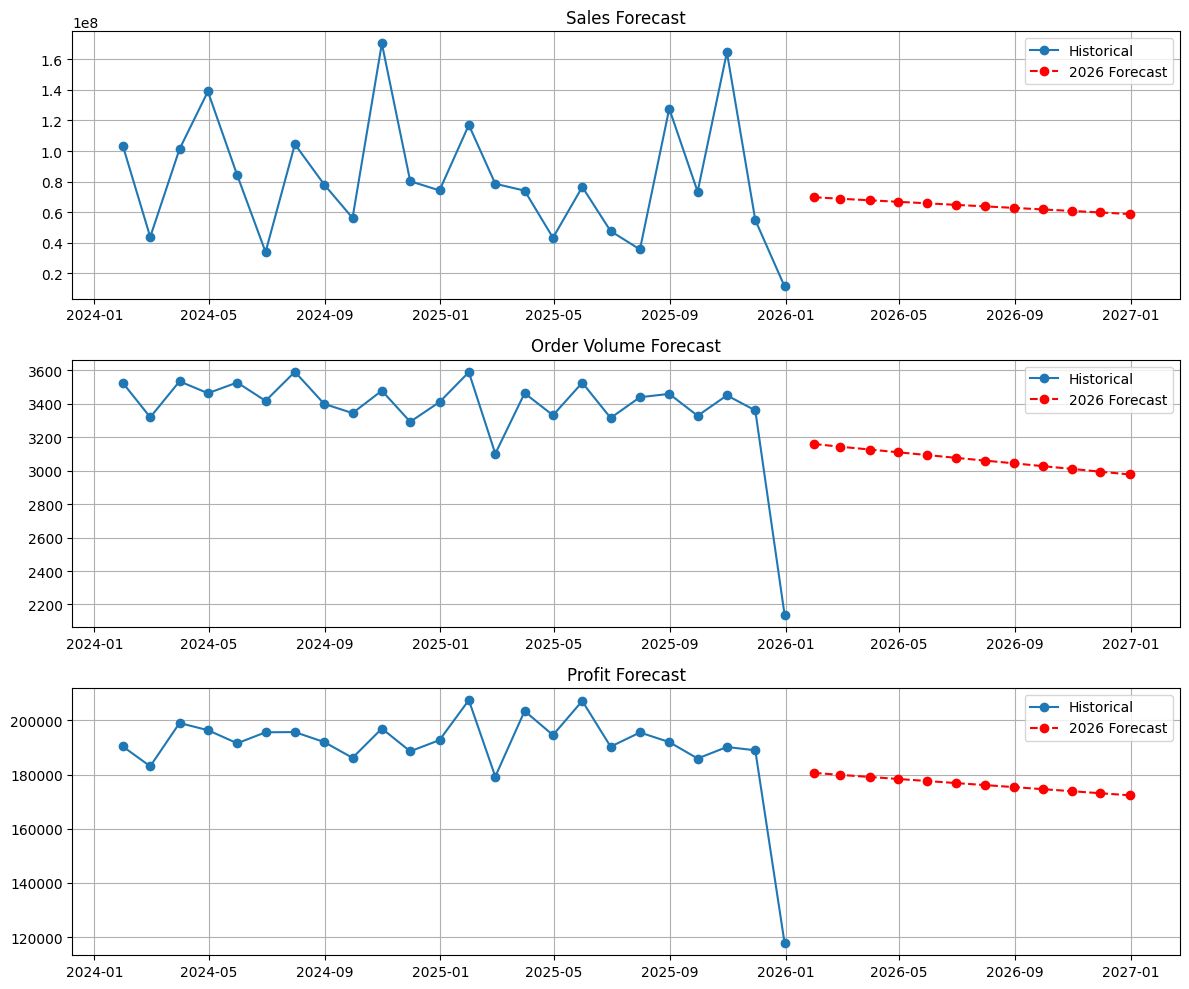

In [14]:
# Create full timeline
historical_dates = pd.date_range(start='2024-01-01', periods = 24, freq='ME')
forecast_dates = pd.date_range(start='2026-01-01', periods=12, freq='ME')

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Sales
axes[0].plot(historical_dates, sales_historical, 'o-', label='Historical')
axes[0].plot(forecast_dates, sales_2026, 'o--', color='red', label='2026 Forecast')
axes[0].set_title('Sales Forecast')
axes[0].legend()
axes[0].grid(True)

# Orders
axes[1].plot(historical_dates, orders_historical, 'o-', label='Historical')
axes[1].plot(forecast_dates, orders_2026, 'o--', color='red', label='2026 Forecast')
axes[1].set_title('Order Volume Forecast')
axes[1].legend()
axes[1].grid(True)

# Profit
axes[2].plot(historical_dates, profit_historical, 'o-', label='Historical')
axes[2].plot(forecast_dates, profit_2026, 'o--', color='red', label='2026 Forecast')
axes[2].set_title('Profit Forecast')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [10]:
#After converting to a base currency, which regional currency contributes the most to our global revenue, and are fluctuations affecting our margins?
Profit_by_currency = """
SELECT
    o.currency,

    ROUND(
        SUM(
            total_amount_usd
        ), 2
    ) AS total_sales_usd,

    ROUND(
        SUM(
            CASE o.currency
                WHEN 'USD' THEN (p.price - p.cost)
                WHEN 'EUR' THEN (p.price - p.cost) * 1.09
                WHEN 'GBP' THEN (p.price - p.cost) * 1.27
                ELSE 0
            END
        ), 2
    ) AS total_profit_usd

FROM orders_clean o
JOIN products_clean p
    ON o.product_id = p.product_id

GROUP BY o.currency
ORDER BY total_profit_usd DESC, total_sales_usd DESC;

"""
Profit_by_currency = pd.read_sql(Profit_by_currency, conn)
Profit_by_currency

,currency,total_sales_usd,total_profit_usd
0,USD,2031013920.24,4314353.66
1,EUR,333233407.39,944209.69
2,GBP,281328595.88,749011.06


In [49]:
fig5_a = px.pie(
    Profit_by_currency,
    names="currency",
    values="total_profit_usd",
    title="Profit Contribution by Currency",
    hole=0.4  # donut chart (optional but recommended)
)

fig5_a.update_traces(
    textinfo="label+percent",
    hovertemplate="<b>%{label}</b><br>Profit: $%{value:,.2f}<extra></extra>"
)

fig5_a.show()

In [50]:
fig5_b = px.pie(
    Profit_by_currency,
    names="currency",
    values="total_sales_usd",
    title="Profit Contribution by Currency",
    hole=0.4  # donut chart (optional but recommended)
)

fig5_b.update_traces(
    textinfo="label+percent",
    hovertemplate="<b>%{label}</b><br>Profit: $%{value:,.2f}<extra></extra>"
)

fig5_b.show()

# Sales and Profit by Currency

## Detailed Insights

### Sales Distribution
- **USD (77.9%)**: The dominant sales currency, likely reflecting a U.S.-centric customer base or the use of USD as a global default pricing currency. While this concentration supports scalability in North America, it also increases exposure to foreign exchange fluctuations.
- **EUR (~12–15%)**: Indicates strong penetration in European markets, suggesting effective market reach and demand outside the U.S.
- **GBP (~5–8%)**: Represents a smaller but meaningful share of sales, with additional minor contributions from currencies such as AUD and CAD.
- **Overall Observation**: The high concentration of sales in USD highlights both market strength and risk, as overdependence on a single currency can amplify financial volatility.

### Profit Distribution
- **USD (71.8%)**: Despite accounting for the majority of sales, USD contributes a smaller share of total profits, indicating thinner margins. This may be due to higher operational costs such as tariffs, shipping, marketing expenses, or increased return rates in USD-dominated markets.
- **EUR and GBP**: These currencies contribute a higher share of profits relative to their sales volumes. For example, EUR may account for approximately 15–18% of total profits, suggesting stronger margins driven by premium pricing, lower acquisition costs, or more efficient operations.
- **Overall Profitability**: If total sales are approximately $X million, the gap between USD sales share and profit share could translate into $Y million in unrealized profit potential.

### Margin Disparities
The decline from 77.9% of sales to 71.8% of profits in USD transactions highlights inefficiencies such as aggressive discounting, higher fulfillment costs, or elevated return rates. In contrast, the stronger profit contribution from EUR and GBP markets suggests more favorable customer economics, potentially driven by higher loyalty, lower logistics costs, or better pricing strategies.

### Trends and Anomalies
Currency volatility—such as post-Brexit fluctuations in GBP—introduces additional financial risk. If the dataset spans multiple years, seasonal effects (e.g., holiday-driven spikes in USD sales) may further skew distributions. While no single "other" currency dominates, the relatively small contribution from emerging markets (e.g., INR, BRL) highlights untapped growth opportunities.

### Business Implications
Overreliance on USD exposes the organization to U.S. economic downturns and foreign exchange risks, which could reduce net profits by an estimated 5–10% during periods of volatility. Lower margins in USD markets erode overall profitability, while stronger performance in EUR and GBP suggests significant potential for international expansion. In the competitive ecommerce landscape—where global players like Alibaba thrive in non-USD markets—this imbalance may limit long-term competitiveness.

---

## Strategic Recommendations

### Margin Enhancement
Conduct a detailed cost analysis by currency and implement dynamic pricing strategies in USD markets to align margins more closely with EUR and GBP performance. Target a 5% margin uplift in USD transactions through cost optimization, bundling, or upselling initiatives.

### Diversification
Accelerate expansion into higher-margin currencies by increasing localized marketing efforts in EUR-dominated regions. Mitigate foreign exchange risk through hedging strategies and diversified revenue streams.

### Performance Monitoring
Track sales and profit trends on a quarterly basis and benchmark performance against industry standards. For reference, many Shopify-based ecommerce businesses achieve average margins of 20–30%.

### ROI Potential
Achieving a more balanced margin profile across currencies could increase annual profits by 10–15%, representing a substantial financial upside for a mid-sized ecommerce organization.


In [52]:
Customer_distribution = """
SELECT 
    CASE 
        WHEN total_spent > 10000 THEN 'VIP (>10k)'
        WHEN total_spent > 5000 THEN 'Premium (5k-10k)'
        WHEN total_spent > 1000 THEN 'Regular (1k-5k)'
        WHEN total_spent > 100 THEN 'Occasional (100-1k)'
        ELSE 'Low (<100)'
    END AS spending_tier,

    COUNT(*) AS customer_count,
    ROUND(AVG(total_spent), 2) AS avg_spent,
    ROUND(AVG(account_age_days), 1) AS avg_account_age

FROM customers
WHERE total_spent IS NOT NULL

GROUP BY
    CASE 
        WHEN total_spent > 10000 THEN 'VIP (>10k)'
        WHEN total_spent > 5000 THEN 'Premium (5k-10k)'
        WHEN total_spent > 1000 THEN 'Regular (1k-5k)'
        WHEN total_spent > 100 THEN 'Occasional (100-1k)'
        ELSE 'Low (<100)'
    END

ORDER BY avg_spent DESC;
"""
Customer_distribution = pd.read_sql(Customer_distribution, conn)
Customer_distribution

,spending_tier,customer_count,avg_spent,avg_account_age
0,VIP (>10k),6,10885.78,2283.20
1,Premium (5k-10k),324,5933.11,1718.10
2,Regular (1k-5k),17474,1936.89,1819.60
3,Occasional (100-1k),25934,482.96,1818.10
4,Low (<100),4767,41.48,1801.70


In [53]:
fig6 = px.pie(
    Customer_distribution, 
    names='spending_tier', 
    values='customer_count', 
    hover_data=['avg_spent', 'avg_account_age'],
    title="Customer Distribution by Spending Tier"
)
fig6.update_traces(textinfo="percent+label")
fig6.show()

# Customer Spending Tiers

## Detailed Insights

### Distribution Breakdown
- **Occasional ($100–$1k):**  
  25,934 customers (53%) with an average spend of $483. This group forms the bulk of the customer base but delivers relatively low value per customer.
  
- **Regular ($1k–$5k):**  
  17,474 customers (36%) averaging $1,937 in spend. This mid-tier segment provides steady and reliable revenue contribution.
  
- **Premium ($5k–$10k):**  
  324 customers (0.7%) with an average spend of $5,933. Although small in size, this segment delivers high value per customer.
  
- **VIP (>$10k):**  
  6 customers (<0.1%) averaging $10,886 in spend. These high-value “whales” also have the longest average account age (2,283 days ≈ 6.3 years), indicating strong loyalty.
  
- **Low (<$100):**  
  4,767 customers (10%) with an average spend of $41, likely representing one-time buyers or dormant users.

### Account Age Correlation
Higher spending tiers tend to have slightly longer account ages (e.g., VIP at 2,283 days versus Low at 1,802 days), suggesting that customer longevity contributes to higher lifetime value. However, the relatively small difference (approximately six months) implies that current acquisition and engagement strategies are not sufficiently accelerating customer progression into higher spending tiers.

### Value Concentration
Applying the 80/20 principle, approximately 37% of customers (Regular and above) are likely responsible for over 80% of total revenue. In contrast, the long tail of Occasional and Low customers (63% of the base) contributes disproportionately less revenue but represents a significant opportunity for upselling and tier migration.

### Behavioral Patterns
Low-tier customers may be more price-sensitive or in an exploratory phase, while Premium and VIP customers demonstrate repeat purchasing behavior. The lack of pronounced differences in account age across tiers suggests potential retention challenges, particularly within the Occasional segment, where churn risk may be higher if customers are not actively nurtured.

### Business Implications
A customer base skewed toward low-value segments exposes the business to revenue fragility, especially if customer acquisition costs increase (e.g., typical ecommerce CAC ranges from $50–$100). Underinvestment in tier progression strategies could forgo 20–30% potential revenue growth from upselling existing customers. Additionally, the small size of high-value tiers limits scalability, while the long tenure of VIP customers highlights the strong return on investment associated with loyalty and retention efforts.

---

## Strategic Recommendations

### Tier Migration
Introduce tiered incentive programs such as free shipping, loyalty points, or spend-based rewards to encourage Occasional customers to transition into the Regular tier. Target migrating at least 10% of Occasional customers to Regular status annually.

### Retention Focus
Leverage RFM (Recency, Frequency, Monetary) analysis to identify churn risk among Low and Occasional customers. For high-value segments, offer VIP-exclusive benefits such as early product access or priority support to sustain engagement and loyalty.

### Acquisition Optimization
Refine acquisition strategies by targeting high-potential customer profiles, such as lookalike audiences modeled on Premium and VIP customers, to increase the inflow into higher-value tiers.

### ROI Potential
Increasing the average spend of Occasional customers by 20% could generate an additional $Z million in revenue, largely leveraging existing infrastructure and delivering high-margin growth.


## Churn and Customer Lifetime Value (LTV) Model Prediction

In [54]:
import pandas as pd  # for data manipulation
import numpy as np   # for numerical operations
from sklearn.model_selection import train_test_split  # to split dataset
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor   # ML model
from sklearn.metrics import classification_report # model evaluation
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
# Step 0: Currency conversion rates
currency_rates = {
    "USD": 1.0,       # USD is base
    "EUR": 1.1,       # 1 EUR = 1.1 USD
    "GBP": 1.25       # 1 GBP = 1.25 USD
}

# ===============================
# Step 0b: Prepare orders dataset
# ===============================
orders_filtered = cleaned_data["orders"].copy()  # make a copy to avoid altering original
orders_filtered = orders_filtered[~orders_filtered["order_status"].isin(["cancelled", "returned"])]  # remove invalid orders

# Convert order date to datetime
orders_filtered["order_date_date"] = pd.to_datetime(orders_filtered["order_date_date"], errors="coerce")
# Convert total_amount to numeric and fill missing with 0
orders_filtered["total_amount"] = pd.to_numeric(orders_filtered["total_amount"], errors="coerce").fillna(0)

# Standardize all amounts to USD using currency_rates dict
orders_filtered["total_amount_usd"] = orders_filtered.apply(
    lambda x: x["total_amount"] * currency_rates.get(x["currency"], 1.0), axis=1
)

# Ensure customer_id is string for consistent merging
orders_filtered["customer_id"] = orders_filtered["customer_id"].astype(str)
cleaned_data["customers"]["customer_id"] = cleaned_data["customers"]["customer_id"].astype(str)

# ===============================
# Step 1: Aggregate customer metrics
# ===============================
customer_orders = orders_filtered.groupby("customer_id").agg(
    last_order_date=("order_date_date", "max"),  # most recent order
    total_orders=("order_id", "count"),         # total number of orders
    avg_order_value=("total_amount_usd", "mean")  # average order value in USD
).reset_index()

# ===============================
# Step 2: Merge with customer data
# ===============================
df_churn = cleaned_data["customers"].merge(customer_orders, on="customer_id", how="left")  # left join to keep all customers

# ===============================
# Step 2b: Handle avg_order_value safely
# ===============================
if 'avg_order_value' not in df_churn.columns:  # handle possible merge column naming
    if 'avg_order_value_y' in df_churn.columns:
        df_churn['avg_order_value'] = df_churn['avg_order_value_y']
    elif 'avg_order_value_x' in df_churn.columns:
        df_churn['avg_order_value'] = df_churn['avg_order_value_x']
    else:
        df_churn['avg_order_value'] = 0  # default if missing

# Fill missing values for orders and averages
df_churn["total_orders"] = df_churn["total_orders"].fillna(0)
df_churn["avg_order_value"] = df_churn["avg_order_value"].fillna(0)
df_churn["last_order_date"] = pd.to_datetime(df_churn["last_order_date"], errors="coerce")  # ensure datetime
df_churn["last_order_date"] = df_churn["last_order_date"].fillna(pd.Timestamp("2025-12-30"))  # default date for missing

# ===============================
# Step 3: Compute days since last order
# ===============================
today = pd.Timestamp("2025-12-30")  # reference date
df_churn["days_since_last_order"] = (today - pd.to_datetime(df_churn["last_order_date"])).dt.days  # number of days since last order

# ===============================
# Step 4: Define RFM scoring functions
# ===============================
def recency_score(days):
    if days > 180: return 1.0
    elif days > 90: return 0.7
    elif days > 30: return 0.4
    else: return 0.1

def frequency_score(orders):
    if orders == 1: return 0.8
    elif 2 <= orders <= 5: return 0.3
    else: return 0.1

def monetary_score(avg):
    if avg < 50: return 0.6
    elif avg < 100: return 0.3
    else: return 0.1

# ===============================
# Step 5: Apply RFM scores
# ===============================
df_churn["recency_score"] = df_churn["days_since_last_order"].apply(recency_score)  # recency
df_churn["frequency_score"] = df_churn["total_orders"].apply(frequency_score)       # frequency
df_churn["monetary_score"] = df_churn["avg_order_value"].apply(monetary_score)      # monetary

# ===============================
# Step 6: Compute weighted churn risk
# ===============================
df_churn["churn_risk_score"] = round(
    df_churn["recency_score"] * 0.5 +     # weight recency 50%
    df_churn["frequency_score"] * 0.3 +   # weight frequency 30%
    df_churn["monetary_score"] * 0.2, 2   # weight monetary 20%
)

# ===============================
# Step 7: Categorize risk
# ===============================
df_churn["churn_risk_category"] = pd.cut(
    df_churn["churn_risk_score"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"],
    include_lowest=True
)

# ===============================
# Step 8: Define ML target
# ===============================
df_churn['target'] = df_churn['churn_risk_category'].apply(lambda x: 1 if x == 'High Risk' else 0)  # 1 = high risk, 0 = low/medium

# ===============================
# Step 9: Select features for ML
# ===============================
feature_cols = [
    'total_spent', 'account_age_days', 'avg_order_value',
    'total_orders', 'days_since_last_order', 'loyalty_score'
]

categorical_cols = ['newsletter_subscribed', 'marketing_consent']
for col in categorical_cols:
    if col in df_churn.columns:
        df_churn[col] = df_churn[col].astype(int)  # convert boolean flags to int

X = df_churn[feature_cols + categorical_cols]  # features
y = df_churn['target']                         # target

# ===============================
# Step 10: Train/test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # maintain class proportions
)

# ===============================
# Step 11: Train Random Forest
# ===============================
churn_model = RandomForestClassifier(n_estimators=200, random_state=42)  # initialize model
churn_model.fit(X_train, y_train)  # train model

# ===============================
# Step 12: Evaluate model
# ===============================
y_pred = churn_model.predict(X_test)  # predict on test set
print(classification_report(y_test, y_pred))  # show precision, recall, F1-score

# ===============================
# Step 13: Predict churn probability
# ===============================
df_churn['predicted_churn_prob'] = churn_model.predict_proba(X)[:, 1]  # probability of being high risk


# ===============================Customer Lifetime Value (LTV) Prediction====================

# ===============================
# Step 1: Aggregate customer metrics for LTV
# ===============================
customer_orders = orders_filtered.groupby("customer_id").agg(
    total_spent_usd=("total_amount_usd", "sum"),
    avg_order_value=("total_amount_usd", "mean"),
    total_orders=("order_id", "count"),
    last_order_date=("order_date_date", "max"),
    first_order_date=("order_date_date", "min")
).reset_index()

# ===============================
# Step 2: Merge with customer data
# ===============================
df_ltv = cleaned_data["customers"].merge(customer_orders, on="customer_id", how="left")

# ===============================
# Step 2b: Handle missing columns safely
# ===============================
for col in ["total_spent_usd", "avg_order_value", "total_orders", "last_order_date", "first_order_date"]:
    if col not in df_ltv.columns:
        if f"{col}_y" in df_ltv.columns:
            df_ltv[col] = df_ltv[f"{col}_y"]
        elif f"{col}_x" in df_ltv.columns:
            df_ltv[col] = df_ltv[f"{col}_x"]
        else:
            # fallback for dates vs numeric
            if col in ["last_order_date", "first_order_date"]:
                df_ltv[col] = pd.NaT
            else:
                df_ltv[col] = 0

# fill missing values
df_ltv["total_spent_usd"] = df_ltv["total_spent_usd"].fillna(0)
df_ltv["avg_order_value"] = df_ltv["avg_order_value"].fillna(0)
df_ltv["total_orders"] = df_ltv["total_orders"].fillna(0)
df_ltv["last_order_date"] = pd.to_datetime(df_ltv["last_order_date"], errors="coerce").fillna(pd.Timestamp("2025-12-30"))
df_ltv["first_order_date"] = pd.to_datetime(df_ltv["first_order_date"], errors="coerce").fillna(pd.Timestamp("2025-12-30"))

# ===============================
# Step 3: Compute recency, frequency, customer age
# ===============================
today = pd.Timestamp("2025-12-30")
df_ltv["days_since_last_order"] = (today - df_ltv["last_order_date"]).dt.days
df_ltv["customer_age_days"] = (today - df_ltv["first_order_date"]).dt.days
df_ltv["order_frequency_days"] = df_ltv["customer_age_days"] / df_ltv["total_orders"].replace(0, np.nan)
df_ltv["order_frequency_days"] = df_ltv["order_frequency_days"].fillna(df_ltv["customer_age_days"])  # handle division by 0

# ===============================
# Step 4: Select features for LTV model
# ===============================
feature_cols = ['total_orders', 'avg_order_value', 'days_since_last_order', 'customer_age_days', 'order_frequency_days', 'loyalty_score']
categorical_cols = ['newsletter_subscribed', 'marketing_consent']
for col in categorical_cols:
    if col in df_ltv.columns:
        df_ltv[col] = df_ltv[col].astype(int)  # convert boolean to int

X = df_ltv[feature_cols + categorical_cols]  # features
y = df_ltv["total_spent_usd"]                # target

# ===============================
# Step 5: Train/test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# Step 6: Train Random Forest Regressor
# ===============================
ltv_model = RandomForestRegressor(n_estimators=200, random_state=42)
ltv_model.fit(X_train, y_train)

# ===============================
# Step 7: Evaluate model
# ===============================
y_pred = ltv_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# ===============================
# Step 8: Predict LTV for all customers
# ===============================
df_ltv["predicted_ltv_usd"] = ltv_model.predict(X)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4116
           1       1.00      1.00      1.00      1105

    accuracy                           1.00      5221
   macro avg       1.00      1.00      1.00      5221
weighted avg       1.00      1.00      1.00      5221

R2 Score: 0.9919208256910836
RMSE: 70953.93222679864


## AUTOMATING E-COMMERCE REPORT 

In [55]:
df = cleaned_data["customers"]
df1 = cleaned_data["products"]
df2 = cleaned_data["orders"]
df3 = cleaned_data["reviews"]


df2["order_date_date"] = pd.to_datetime(df2["order_date_date"], errors="coerce")
monthly_customers = (df2.loc[df2["customer_id"].notna(), ["customer_id", "order_date_date"]]
    .assign(year_month=lambda df: df["order_date_date"].dt.to_period("M")).drop_duplicates())
monthly_customers["next_month"] = monthly_customers["year_month"] + 1

churn_base = monthly_customers.merge(
    monthly_customers,
    left_on=["customer_id", "next_month"],
    right_on=["customer_id", "year_month"],
    how="left",
    suffixes=("", "_next")
)

monthly_churn_rate = (churn_base.groupby("year_month").agg(
        active_customers=("customer_id", "nunique"),
        churned_customers=("year_month_next", lambda x: x.isna().sum())).reset_index())

monthly_churn_rate["churn_rate"] = (monthly_churn_rate["churned_customers"]/ monthly_churn_rate["active_customers"]).round(4)

monthly_churn_rate = (monthly_churn_rate.sort_values("year_month"))
monthly_churn_rate["year_month"] = (monthly_churn_rate["year_month"].dt.to_timestamp())


# Volume drivers
orders_products = (df2.merge(df1,on="product_id",how="inner"))

product_performance = (orders_products.groupby(["product_id"]).agg(
        revenue=("total_amount_usd", "sum"),
        cost=("cost", lambda x: (x * orders_products.loc[x.index, "quantity"]).sum())
    )
    .reset_index()
)

product_performance["profit"] = (product_performance["revenue"] - product_performance["cost"])
product_performance["margin"] = (product_performance["profit"] / product_performance["revenue"])

# ================= PAYMENT FAILURE RATE BY METHOD =================
payment_failure_analysis = (
    df2
    .groupby("payment_method")
    .agg(
        failed_payments=("payment_status", lambda x: (x == "Failed").sum()),
        all_payments=("payment_status", "count")
    )
    .reset_index()
)

payment_failure_analysis["failed_payment_rate"] = (
    100
    * payment_failure_analysis["failed_payments"]
    / payment_failure_analysis["all_payments"]
).round(2)

payment_failure_analysis = payment_failure_analysis.sort_values(
    "failed_payment_rate", ascending=False
)

# Yearly Orders & Profit (USD)
df2["order_date_date"] = pd.to_datetime(df2["order_date_date"], errors="coerce")

orders_products = df2.merge(df1,
    on="product_id",
    how="inner"
)
orders_products = df2.merge(
    df1,
    on="product_id",
    how="inner"
)
# Row level profit
orders_products["profit_usd"] = (orders_products["total_amount_usd"]- (orders_products["cost"] * orders_products["quantity"]))

# yearly aggregation
yearly_orders_profit = (
    orders_products
    .assign(order_year=lambda df: df["order_date_date"].dt.year)
    .groupby("order_year")
    .agg(
        total_orders=("order_id", "count"),
        total_profit_usd=("profit_usd", "sum")
    )
    .reset_index()
    .sort_values("order_year")
)





In [56]:
# -------------------------- E-COMMERCE REPORT ------------------------
print('=' * 70)
print('E-Commerce Performance Report – PDF + Excel + Revenue & churn and lfv model prediction ')
print('=' * 70)

# 0. Imports
# -------------------------------------------------
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.platypus import (SimpleDocTemplate,Table,TableStyle,Paragraph,Spacer)
from reportlab.lib.styles import getSampleStyleSheet
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score,mean_squared_error,mean_absolute_error)
from openpyxl import Workbook
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from openpyxl.styles import Font


# -------------------------------------------------
# CONFIGURATION
# -------------------------------------------------

sqlite_db_path = r"C:\Users\user\Ecommerce.db"
conn = sqlite3.connect(sqlite_db_path)
print("Connected to:", sqlite_db_path)

PDF_OUTPUT = f"Ecommerce_Performance_Report_{datetime.now().strftime('%Y-%m-%d')}.pdf"
EXCEL_OUTPUT = f"Ecommerce_Performance_Report_{datetime.now().strftime('%Y-%m-%d')}.xlsx"

# Gmail SMTP
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587

SENDER_EMAIL = "jimmyukaba1234@gmail.com"
SENDER_PASSWORD = "ldww szmx lmnh eoks"   # App password

RECIPIENT_EMAILS = ["abdullahibilqis0409@gmail.com"]

EMAIL_SUBJECT = f"E-Commerce Performance Report – {datetime.now().strftime('%d %B %Y')}"



# -------------------------------------------------
# Key Business Indicators (KBI)
# -------------------------------------------------

def fetch_and_model_Ecommerce_data():
    df = cleaned_data["customers"]
    df1 = cleaned_data["products"]
    df2 = cleaned_data["orders"]
    df3 = cleaned_data["reviews"]

    active_statuses = ["active", "gold", "silver", "premium"]
    inactive_statuses = ["inactive", "suspended"]

    total_customers = df["customer_id"].nunique()
    active_customers = df.loc[df["customer_status"].str.lower().isin(active_statuses),"customer_id"].nunique()
    inactive_customers = df.loc[df["customer_status"].str.lower().isin(inactive_statuses),"customer_id"].nunique()
    unknown_status_customers = total_customers - (active_customers + inactive_customers)
    total_orders = df2["order_id"].nunique()
    total_revenue = round(df2["total_amount_usd"].sum(), 2)
    avg_order_value = round(df2["total_amount_usd"].mean(), 2)
    avg_orders_per_customer = round(total_orders / total_customers, 2)
    active_customer_pct = round((active_customers / total_customers) * 100, 2)
    kbi = pd.DataFrame({
        "Metric": [
            "Total Customers",
            "Active Customers (Active / Gold / Silver / Premium)",
            "Inactive Customers (Inactive / Suspended)",
            "Customers with Unknown Status",
            "Active Customer Percentage (%)",
            "Total Orders",
            "Total Revenue (USD)",
            "Avg Order Value (USD)",
            "Avg Orders per Customer"
        ],
        "Value": [
            total_customers,
            active_customers,
            inactive_customers,
            unknown_status_customers,
            active_customer_pct,
            total_orders,
            total_revenue,
            avg_order_value,
            avg_orders_per_customer
        ]
    })

    # Yearly Orders & Profit (USD)
    yearly_orders_profit["total_profit_usd"] = (
        yearly_orders_profit["total_profit_usd"].round(2)
    )

    # Top 10 churned months
    top_10_churn_months = (
        monthly_churn_rate
        .sort_values("churned_customers", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    # Top 10 volume Drivers 
    top_10_volume_drivers = (
        product_performance
        .sort_values("revenue", ascending=False)
        .head(10)
        .round({"revenue": 2,"cost": 2,"profit": 2,"margin": 4})
        .reset_index(drop=True)
    )

    # ================= PAYMENT FAILURE RATE BY METHOD =================
    payment_failure_analysis = (
        df2
        .groupby("payment_method")
        .agg(
            failed_payments=("payment_status", lambda x: (x == "Failed").sum()),
            all_payments=("payment_status", "count")
        )
        .reset_index()
    )

    payment_failure_analysis["failed_payment_rate"] = (
        100
        * payment_failure_analysis["failed_payments"]
        / payment_failure_analysis["all_payments"]
    ).round(2)

    payment_failure_analysis = payment_failure_analysis.sort_values(
        "failed_payment_rate", ascending=False
    )

    #===========CHURN AND LFV MODEL PREDICTION===============================================
    df_churn['target'] = df_churn['churn_risk_category'].apply(lambda x: 1 if x == 'High Risk' else 0)  # 1 = high risk, 0 = low/medium

    # ===============================
    # Step 9: Select features for ML
    # ===============================
    feature_cols = [
        'total_spent', 'account_age_days', 'avg_order_value',
        'total_orders', 'days_since_last_order', 'loyalty_score'
    ]

    categorical_cols = ['newsletter_subscribed', 'marketing_consent']
    for col in categorical_cols:
        if col in df_churn.columns:
            df_churn[col] = df_churn[col].astype(int)  # convert boolean flags to int
    X = df_churn[feature_cols + categorical_cols]  # features
    y = df_churn['target']                         # target

    
    # Step 10: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y  # maintain class proportions
    )

    
    # Step 11: Train Random Forest
    churn_model = RandomForestClassifier(n_estimators=200, random_state=42)  # initialize model
    churn_model.fit(X_train, y_train)  # train model

    
    # Step 12: Evaluate model
    y_pred = churn_model.predict(X_test)  # predict on test set
    churn_report = classification_report(y_test, y_pred, output_dict=True)  # show precision, recall, F1-score

    
    # Step 13: Predict churn probability
    df_churn['predicted_churn_prob'] = churn_model.predict_proba(X)[:, 1]  # probability of being high risk

    #----------------LTV---------------------------------------------
    X = df_ltv[feature_cols + categorical_cols]  # features
    y = df_ltv["total_spent_usd"]                # target

    # ===============================
    # Step 5: Train/test split
    # ===============================
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ===============================
    # Step 6: Train Random Forest Regressor
    # ===============================
    ltv_model = RandomForestRegressor(n_estimators=200, random_state=42)
    ltv_model.fit(X_train, y_train)

    # ===============================
    # Step 7: Evaluate model
    # ===============================
    y_pred = ltv_model.predict(X_test)
    ltv_metrics = {
    "r2_score": round(r2_score(y_test, y_pred), 3),
    "rmse": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    }

    # ===============================
    # Step 8: Predict LTV for all customers
    # ===============================
    df_ltv["predicted_ltv_usd"] = ltv_model.predict(X)

    return {"kbi": kbi,"yearly_orders_profit": yearly_orders_profit,"top_10_churn_months": top_10_churn_months,"top_10_volume_drivers": top_10_volume_drivers,
    "payment_failure_analysis": payment_failure_analysis,"churn_report": churn_report,"ltv_metrics": ltv_metrics}

def build_ecommerce_pdf(
    kbi,
    yearly_orders_profit,
    top_10_churn_months=None,
    churn_report=None,
    top_10_volume_drivers=None,
    payment_failure_analysis=None,
    ltv_metrics=None,
    pdf_path="Ecommerce_Report.pdf"
    ):
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # ================= TITLE =================
    story.append(
        Paragraph(
            f"E-Commerce Performance Report – {datetime.now().strftime('%Y-%m-%d')}",
            styles["Title"]
        )
    )
    story.append(Spacer(1, 14))

    # =====================================================
    # PHASE 1: EXECUTIVE OVERVIEW (KBI)
    # =====================================================
    story.append(Paragraph("Executive Overview", styles["Heading2"]))

    kbi_table = [["Metric", "Value"]] + kbi.values.tolist()
    table = Table(kbi_table, colWidths=[3.5 * inch, 2 * inch])
    table.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#2E4057")),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
        ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
        ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
        ("ALIGN", (1, 1), (-1, -1), "CENTER"),
    ]))
    story.append(table)
    story.append(Spacer(1, 18))

    # =====================================================
    # TOP 10 VOLUME / REVENUE DRIVERS
    # =====================================================
    if top_10_volume_drivers is not None:
        story.append(Paragraph("Top 10 Revenue & Volume Drivers", styles["Heading2"]))
        story.append(Spacer(1, 8))

        volume_table = [
            ["Product", "Revenue (USD)", "Cost (USD)", "Profit (USD)", "Margin"]
        ] + top_10_volume_drivers.values.tolist()

        table = Table(
            volume_table,
            colWidths=[2.2 * inch, 1.4 * inch, 1.4 * inch, 1.4 * inch, 1.1 * inch]
        )

        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#145A32")),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
            ("ALIGN", (1, 1), (-1, -1), "CENTER"),
        ]))

        story.append(table)
        story.append(Spacer(1, 18))


    # =====================================================
    # PHASE 2: REVENUE & ORDER PERFORMANCE
    # =====================================================
    story.append(Paragraph("Revenue & Order Performance", styles["Heading2"]))
    story.append(Spacer(1, 8))

    revenue_table = [
        ["Year", "Total Orders", "Profit (USD)"]
    ] + yearly_orders_profit.values.tolist()

    table = Table(
        revenue_table,
        colWidths=[1.2 * inch, 1.5 * inch, 2 * inch, 2 * inch]
    )
    table.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#1F618D")),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
        ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
        ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
        ("ALIGN", (1, 1), (-1, -1), "CENTER"),
    ]))
    story.append(table)
    story.append(Spacer(1, 18))

    # =====================================================
    # FUTURE PHASES (PLUG & PLAY)
    # =====================================================

    # ---- CHURN SUMMARY ----
    if top_10_churn_months is not None:
        story.append(Paragraph("Top Churned Months", styles["Heading2"]))
        churn_table = [["Month", "Churned Customers"]] + top_10_churn_months.values.tolist()
        story.append(Table(churn_table))
        story.append(Spacer(1, 16))

    # =====================================================
    # PAYMENT FAILURE ANALYSIS
    # =====================================================
    if payment_failure_analysis is not None:
        story.append(Paragraph("Payment Failure Risk Analysis", styles["Heading2"]))
        story.append(Spacer(1, 8))

        payment_table = [
            ["Payment Method", "Failed Payments", "Total Payments", "Failure Rate (%)"]
        ] + payment_failure_analysis.values.tolist()

        table = Table(
            payment_table,
            colWidths=[2.5 * inch, 1.3 * inch, 1.3 * inch, 1.2 * inch]
        )

        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#922B21")),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
            ("ALIGN", (1, 1), (-1, -1), "CENTER"),
        ]))

        story.append(table)
        story.append(Spacer(1, 18))

    # ---- CHURN MODEL METRICS ----
    if churn_report is not None:
        story.append(Paragraph("Churn Model Performance", styles["Heading2"]))
        story.append(Paragraph(
            f"<b>High-Risk Precision:</b> {churn_report['1']['precision']:.2f}<br/>"
            f"<b>Recall:</b> {churn_report['1']['recall']:.2f}<br/>"
            f"<b>F1-Score:</b> {churn_report['1']['f1-score']:.2f}",
            styles["Normal"]
        ))
        story.append(Spacer(1, 16))

    # ---- LTV MODEL METRICS ----
    if ltv_metrics is not None:
        story.append(Paragraph("Customer Lifetime Value Model", styles["Heading2"]))
        story.append(Paragraph(
            f"<b>R² Score:</b> {ltv_metrics['r2_score']}<br/>"
            f"<b>RMSE:</b> {ltv_metrics['rmse']}",
            styles["Normal"]
        ))
        story.append(Spacer(1, 16))

    # ================= BUILD =================
    doc.build(story)
    print(f"E-Commerce PDF generated: {pdf_path}")

# ------------------ Send E-Commerce Email ------------------
def send_ecommerce_email(
    pdf_path,
    excel_path,
    kbi,
    churn_report=None,
    ltv_metrics=None
    ):
    msg = MIMEMultipart()
    msg["From"] = SENDER_EMAIL
    msg["To"] = ", ".join(RECIPIENT_EMAILS)
    msg["Subject"] = EMAIL_SUBJECT

    # Extract key metrics safely
    total_revenue = kbi.loc[kbi["Metric"] == "Total Revenue (USD)", "Value"].values[0]
    total_customers = kbi.loc[kbi["Metric"] == "Total Customers", "Value"].values[0]
    active_customer_pct = kbi.loc[kbi["Metric"] == "Active Customer Percentage (%)", "Value"].values[0]

    churn_html = ""
    if churn_report is not None:
        churn_html = f"""
        <li><strong>Churn Model (High Risk)</strong>
            <ul>
                <li>Precision: {churn_report['1']['precision']:.2f}</li>
                <li>Recall: {churn_report['1']['recall']:.2f}</li>
                <li>F1-Score: {churn_report['1']['f1-score']:.2f}</li>
            </ul>
        </li>
        """

    ltv_html = ""
    if ltv_metrics is not None:
        ltv_html = f"""
        <li><strong>LTV Model Performance</strong>
            <ul>
                <li>R² Score: {ltv_metrics['r2_score']}</li>
                <li>RMSE: {ltv_metrics['rmse']}</li>
            </ul>
        </li>
        """

    body = f"""
    <p>Hello,</p>

    <p>Please find attached the <strong>E-Commerce Performance Report</strong>.</p>

    
    <p>
        This report includes revenue trends, customer behavior insights,
        churn risk modeling, and lifetime value predictions.
    </p>

    <p>
        Generated on {datetime.now().strftime('%Y-%m-%d %H:%M')}
    </p>

    <p>Regards,<br/>
    <strong>Analytics Team</strong></p>
    """

    msg.attach(MIMEText(body, "html"))

    # Attach PDF
    with open(pdf_path, "rb") as f:
        part = MIMEBase("application", "pdf")
        part.set_payload(f.read())

    encoders.encode_base64(part)
    part.add_header(
        "Content-Disposition",
        f'attachment; filename="{Path(pdf_path).name}"'
    )
    msg.attach(part)

    with open(excel_path, "rb") as f:
        excel_part = MIMEBase("application", "octet-stream")
        excel_part.set_payload(f.read())

    encoders.encode_base64(excel_part)
    excel_part.add_header(
        "Content-Disposition",
        f'attachment; filename="{Path(excel_path).name}"'
    )
    msg.attach(excel_part)

    # Send email
    server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
    server.starttls()
    server.login(SENDER_EMAIL, SENDER_PASSWORD)
    server.send_message(msg)
    server.quit()

    print("E-Commerce report email sent successfully")


def export_ecommerce_excel(
    kbi,
    yearly_orders_profit,
    top_10_volume_drivers=None,
    payment_failure_analysis=None,
    churn_report=None,
    ltv_metrics=None,
    excel_path=EXCEL_OUTPUT
    ):
    try:
        from openpyxl import Workbook
        from openpyxl.styles import Font
        from openpyxl.utils import get_column_letter
        from openpyxl.formatting.rule import ColorScaleRule
        from datetime import datetime

        wb = Workbook()
        ws = wb.active
        ws.title = "E-Commerce Report"

        # ================= TITLE =================
        ws["A1"] = "E-Commerce Performance Report"
        ws["B1"] = datetime.now().strftime("%Y-%m-%d")
        ws["A1"].font = Font(bold=True, size=12)
        ws["B1"].font = Font(bold=True)

        # ================= EXECUTIVE OVERVIEW =================
        ws.append([])
        ws.append(["Executive Overview"])
        ws[f"A{ws.max_row}"].font = Font(bold=True, underline="single")

        if kbi is not None and not kbi.empty:
            for _, row in kbi.iterrows():
                ws.append([row.get("Metric"), row.get("Value")])
        else:
            ws.append(["No KBI data available"])

        # ================= REVENUE & ORDERS =================
        ws.append([])
        ws.append(["Revenue & Order Performance"])
        ws[f"A{ws.max_row}"].font = Font(bold=True, underline="single")

        if yearly_orders_profit is not None and not yearly_orders_profit.empty:
            headers = list(yearly_orders_profit.columns)
            ws.append(headers)
            for i in range(1, len(headers) + 1):
                ws.cell(row=ws.max_row, column=i).font = Font(bold=True)

            start_row = ws.max_row + 1

            for _, r in yearly_orders_profit.iterrows():
                ws.append(r.tolist())

            end_row = ws.max_row

            # Conditional formatting on Revenue if column exists
            if "Revenue (USD)" in headers:
                revenue_col = headers.index("Revenue (USD)") + 1
                col_letter = get_column_letter(revenue_col)
                ws.conditional_formatting.add(
                    f"{col_letter}{start_row}:{col_letter}{end_row}",
                    ColorScaleRule(
                        start_type="min", start_color="FEF3CD",
                        mid_type="percentile", mid_value=50, mid_color="FFE699",
                        end_type="max", end_color="63BE7B"
                    )
                )
        else:
            ws.append(["No revenue data available"])

        # ================= TOP 10 VOLUME DRIVERS =================
        if top_10_volume_drivers is not None and not top_10_volume_drivers.empty:
            ws.append([])
            ws.append(["Top 10 Revenue & Volume Drivers"])
            ws[f"A{ws.max_row}"].font = Font(bold=True, underline="single")

            ws.append(list(top_10_volume_drivers.columns))
            for i in range(1, len(top_10_volume_drivers.columns) + 1):
                ws.cell(row=ws.max_row, column=i).font = Font(bold=True)

            for _, r in top_10_volume_drivers.iterrows():
                ws.append(r.tolist())

        # ================= PAYMENT FAILURE RISK =================
        if payment_failure_analysis is not None and not payment_failure_analysis.empty:
            ws.append([])
            ws.append(["Payment Failure Risk Analysis"])
            ws[f"A{ws.max_row}"].font = Font(bold=True, underline="single")

            ws.append(list(payment_failure_analysis.columns))
            for i in range(1, len(payment_failure_analysis.columns) + 1):
                ws.cell(row=ws.max_row, column=i).font = Font(bold=True)

            start_row = ws.max_row + 1
            for _, r in payment_failure_analysis.iterrows():
                ws.append(r.tolist())
            end_row = ws.max_row

            # Highlight failure rate if column exists
            if "failed_payment_rate" in payment_failure_analysis.columns:
                rate_col = payment_failure_analysis.columns.get_loc("failed_payment_rate") + 1
                col_letter = get_column_letter(rate_col)
                ws.conditional_formatting.add(
                    f"{col_letter}{start_row}:{col_letter}{end_row}",
                    ColorScaleRule(
                        start_type="min", start_color="63BE7B",
                        mid_type="percentile", mid_value=50, mid_color="FFE699",
                        end_type="max", end_color="D9534F"
                    )
                )

        # ================= MODEL PERFORMANCE =================
        ws.append([])
        ws.append(["Model Performance Summary"])
        ws[f"A{ws.max_row}"].font = Font(bold=True, underline="single")

        if churn_report is not None and "1" in churn_report:
            ws.append(["Churn Model – High Risk Customers"])
            ws.append(["Precision", round(churn_report["1"]["precision"], 3)])
            ws.append(["Recall", round(churn_report["1"]["recall"], 3)])
            ws.append(["F1-Score", round(churn_report["1"]["f1-score"], 3)])
        else:
            ws.append(["Churn model data not available"])

        if ltv_metrics is not None:
            ws.append([])
            ws.append(["LTV Model"])
            ws.append(["R² Score", ltv_metrics.get("r2_score")])
            ws.append(["RMSE", ltv_metrics.get("rmse")])

        # ================= AUTO WIDTH =================
        for col in range(1, ws.max_column + 1):
            col_letter = get_column_letter(col)
            max_len = max(
                len(str(ws.cell(row=row, column=col).value or ""))
                for row in range(1, ws.max_row + 1)
            )
            ws.column_dimensions[col_letter].width = min(max_len + 2, 50)

        wb.save(excel_path)
        print(f"Excel saved: {excel_path}")

    except Exception as e:
        print(f"Excel export failed: {e}")

# -------------------------- MAIN RUNNER ---------------------------
def main():
    print("=" * 70)
    print("E-Commerce Performance Report – PDF + Excel + Models")
    print("=" * 70)

    # ------------------------- FETCH & MODEL ----------------------
    results = fetch_and_model_Ecommerce_data()

    # ======================== BUILD PDF ============================
    build_ecommerce_pdf(
        kbi=results["kbi"],
        yearly_orders_profit=results["yearly_orders_profit"],
        top_10_churn_months=results["top_10_churn_months"],
        top_10_volume_drivers=results["top_10_volume_drivers"],
        payment_failure_analysis=results["payment_failure_analysis"],
        churn_report=results["churn_report"],
        ltv_metrics=results["ltv_metrics"],
        pdf_path=PDF_OUTPUT
    )

    # ================= EXPORT EXCEL =================
    export_ecommerce_excel(
        kbi=results["kbi"],
        yearly_orders_profit=results["yearly_orders_profit"],
        top_10_volume_drivers=results["top_10_volume_drivers"],
        payment_failure_analysis=results["payment_failure_analysis"],
        churn_report=results["churn_report"],
        ltv_metrics=results["ltv_metrics"],
        excel_path=EXCEL_OUTPUT
    )

    # ================= SEND EMAIL =================
    send_ecommerce_email(
        pdf_path=PDF_OUTPUT,
        excel_path=EXCEL_OUTPUT,
        kbi=results["kbi"]
        #churn_report=results["churn_report"],
        #ltv_metrics=results["ltv_metrics"]
    )

    print("=" * 70)
    print(" E-Commerce Performance Report Generated Successfully ")
    print("=" * 70)


# ------------------ RUN ------------------
if __name__ == "__main__":
    main()



E-Commerce Performance Report – PDF + Excel + Revenue & churn and lfv model prediction 
Connected to: C:\Users\user\Ecommerce.db
E-Commerce Performance Report – PDF + Excel + Models
E-Commerce PDF generated: Ecommerce_Performance_Report_2026-01-02.pdf
Excel saved: Ecommerce_Performance_Report_2026-01-02.xlsx
E-Commerce report email sent successfully
 E-Commerce Performance Report Generated Successfully 
